# 🎨 Vanilla GAN (Generative Adversarial Network) 완전 정복

## 📚 학습 목표

1. GAN의 기본 개념과 학습 원리 이해
2. Generator와 Discriminator의 역할과 관계 파악
3. TensorFlow와 PyTorch로 Vanilla GAN 구현
4. MNIST 데이터셋으로 손글씨 이미지 생성 실습

---

## 🔥 1. GAN이란 무엇인가?

### 1.1 GAN의 핵심 아이디어

**GAN** (Generative Adversarial Network)은 2014년 Ian Goodfellow가 제안한 생성 모델입니다.

핵심은 **두 개의 신경망이 서로 경쟁하면서 학습**한다는 것입니다:

- **Generator (생성자, G)**: 가짜 데이터를 만드는 역할
  - 노이즈 벡터 z를 입력받아 진짜 같은 이미지를 생성
  - 목표: Discriminator를 속이는 것

- **Discriminator (판별자, D)**: 진짜와 가짜를 구별하는 역할
  - 이미지를 입력받아 진짜일 확률을 출력 (0~1 사이)
  - 목표: 진짜와 가짜를 정확히 구별하는 것


![](https://developers.google.com/static/machine-learning/gan/images/generative_v_discriminative.png?hl=ko)

### 1.2 실생활 비유



**위조지폐범(G) vs 경찰(D)** 로 생각하면 쉽습니다:

1. 위조지폐범(G)이 가짜 지폐를 만듭니다
2. 경찰(D)이 진짜/가짜 지폐를 구별하려고 합니다
3. 위조지폐범은 경찰을 속이기 위해 더 정교한 가짜를 만듭니다
4. 경찰은 더 정확하게 구별하기 위해 실력을 키웁니다
5. 이 과정이 반복되면서 결국 위조지폐범은 진짜 같은 지폐를 만들게 됩니다

---

![](https://developers.google.com/static/machine-learning/gan/images/bad_gan.svg?hl=ko)
학습이 진행될수록 생성자는 판별자를 속일 수 있는 출력을 생성하는 데 가까워집니다.
![](https://developers.google.com/static/machine-learning/gan/images/ok_gan.svg?hl=ko)
마지막으로 생성자 학습이 잘 진행되면 구분자는 진짜와 가짜의 차이를 구분하는 능력이 저하됩니다. 가짜 데이터를 실제 데이터로 분류하기 시작하고 정확성이 떨어집니다.
![](https://developers.google.com/static/machine-learning/gan/images/good_gan.svg?hl=ko)

![](https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg?hl=ko)

## 📐 2. GAN의 수학적 원리

### 2.1 전체 목적 함수

GAN의 학습은 다음 min-max 게임으로 표현됩니다:

$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

여기서:
- $x$: 진짜 데이터 (예: MNIST 이미지)
- $z$: 노이즈 벡터 (보통 표준정규분포에서 샘플링)
- $G(z)$: Generator가 만든 가짜 이미지
- $D(x)$: Discriminator가 x를 진짜라고 판단할 확률

### 2.2 수식 해석

**Discriminator의 관점** (maximize):
- $\log D(x)$를 최대화: 진짜 데이터를 진짜(1)라고 잘 맞추기
- $\log(1 - D(G(z)))$를 최대화: 가짜 데이터를 가짜(0)라고 잘 맞추기

**Generator의 관점** (minimize):
- $\log(1 - D(G(z)))$를 최소화
- 즉, $D(G(z))$를 크게 만들기 → Discriminator를 속이기

### 2.3 실제 학습에서 사용하는 Loss

실제 구현에서는 **Binary Cross Entropy (BCE)** 를 사용합니다:

**Discriminator Loss:**
$$
L_D = -\frac{1}{m}\sum_{i=1}^{m}[\log D(x^{(i)}) + \log(1 - D(G(z^{(i)})))]
$$

**Generator Loss:**
$$
L_G = -\frac{1}{m}\sum_{i=1}^{m}\log D(G(z^{(i)}))
$$

(참고: 실제 코드에서는 이 값을 minimize하므로 음수 부호가 자동으로 처리됩니다)

---

## 🔍 3. 손실 계산 예시 - 숫자로 이해하기

구체적인 예시로 GAN의 학습 과정을 살펴보겠습니다.

### 전제 조건
- 데이터: MNIST (28×28 = 784 픽셀)
- Batch size: 4 (이해를 돕기 위해 작은 값 사용)
- 노이즈 차원: 100

---

### 📥 Step 0: 입력 데이터 준비

**진짜 이미지 (real_images)**
```python
shape: (4, 784)
real_images = [
  [0.12, 0.02, ..., 0.88],   # sample 1
  [0.01, 0.53, ..., 0.24],   # sample 2
  [0.42, 0.12, ..., 0.77],   # sample 3
  [0.91, 0.63, ..., 0.02],   # sample 4
]
```

**노이즈 벡터 (noise)**
```python
shape: (4, 100)
noise = [
  [ 0.1, -0.3, ...  1.2],
  [-1.1,  0.9, ... -0.2],
  [ 0.7,  0.5, ...  0.3],
  [-0.4,  1.0, ...  0.8],
]
```

---

### 🎯 Step 1: Discriminator 학습

#### 1-1. Generator로 가짜 이미지 생성

```python
fake_images = generator(noise)  # shape: (4, 784)
```

예시 값:
```python
fake_images = [
  [-0.22, 0.11, ..., 0.03],
  [ 0.05,-0.77, ..., 0.95],
  [-0.31,-0.02, ..., 0.61],
  [ 0.22, 0.33, ..., 0.71],
]
```

#### 1-2. Discriminator에 진짜/가짜 통과

```python
real_output = discriminator(real_images)  # shape: (4, 1)
fake_output = discriminator(fake_images)  # shape: (4, 1)
```

예시 출력:
```python
real_output = [[0.85], [0.62], [0.91], [0.75]]  # 진짜를 높게 판단
fake_output = [[0.04], [0.15], [0.01], [0.22]]  # 가짜를 낮게 판단
```

**해석**: D는 진짜에 대해 0.62~0.91로 높게, 가짜에 대해 0.01~0.22로 낮게 판단 → 정상!

---

#### 1-3. Discriminator Loss 계산

**진짜에 대한 BCE Loss**
```python
# 목표: D(real) → 1
d_loss_real = BCE(ones, real_output)
```

수식:
$$
L_{D,real} = -\frac{1}{4}\sum_{i=1}^{4}\log D(x_{real}^{(i)})
$$

계산:
```
-log(0.85) = 0.162
-log(0.62) = 0.478
-log(0.91) = 0.094
-log(0.75) = 0.288

평균 = (0.162 + 0.478 + 0.094 + 0.288) / 4 = 0.2555
```

**가짜에 대한 BCE Loss**
```python
# 목표: D(fake) → 0
d_loss_fake = BCE(zeros, fake_output)
```

수식:
$$
L_{D,fake} = -\frac{1}{4}\sum_{i=1}^{4}\log(1 - D(G(z^{(i)})))
$$

계산:
```
-log(1 - 0.04) = 0.0408
-log(1 - 0.15) = 0.1625
-log(1 - 0.01) = 0.0100
-log(1 - 0.22) = 0.2490

평균 = (0.0408 + 0.1625 + 0.0100 + 0.2490) / 4 = 0.1156
```

**총 Discriminator Loss**
```python
d_loss = d_loss_real + d_loss_fake = 0.2555 + 0.1156 = 0.3711
```

---

In [ ]:
loss.backward() # 역전파 진행
optimizer.step() # 최적화 함수 실행 (파라미터 업데이트)

#### 1-4. Discriminator 파라미터 업데이트

```python
grads_d = tape_d.gradient(d_loss, discriminator.trainable_variables)
optimizer_d.apply_gradients(...)
```

수식:
$$
\theta_D \leftarrow \theta_D - \eta_D \nabla_{\theta_D} L_D
$$

**결과**: Discriminator가 진짜는 더 진짜로, 가짜는 더 가짜로 판단하도록 학습됨

---

### 🎨 Step 2: Generator 학습

이제 **Discriminator는 고정(freeze)**하고 **Generator만 업데이트**합니다.

#### 2-1. 새로운 노이즈 샘플링

```python
noise = tf.random.normal([4, 100])
# 예시: [[0.3, 1.2, ..., -0.1], [-0.8, 0.4, ..., 0.6], ...]
```

#### 2-2. 가짜 이미지 생성 및 Discriminator 통과

```python
fake_images = generator(noise)
fake_output = discriminator(fake_images)
```

예시 출력:
```python
fake_output = [[0.12], [0.07], [0.03], [0.18]]  # 여전히 낮은 값
```

**해석**: D가 여전히 "이건 가짜야!"라고 확신하는 중

---

#### 2-3. Generator Loss 계산

```python
# 목표: D(G(z)) → 1 (Discriminator를 속이기!)
g_loss = BCE(ones, fake_output)
```

수식:
$$
L_G = -\frac{1}{4}\sum_{i=1}^{4}\log D(G(z^{(i)}))
$$

계산:
```
-log(0.12) = 2.120
-log(0.07) = 2.659
-log(0.03) = 3.506
-log(0.18) = 1.714

평균 = (2.120 + 2.659 + 3.506 + 1.714) / 4 ≈ 2.5
```

**해석**:
- Loss가 크다 = D가 가짜를 잘 구분하고 있다 = G가 못 만들고 있다
- → G는 더 열심히 학습해야 함!

#### 2-4. Generator 파라미터 업데이트

```python
grads_g = tape_g.gradient(g_loss, generator.trainable_variables)
optimizer_g.apply_gradients(...)
```

수식:
$$
\theta_G \leftarrow \theta_G - \eta_G \nabla_{\theta_G} L_G
$$

**결과**: G는 D(G(z))를 높이는 방향으로 학습됨 → 점점 진짜 같은 이미지 생성

---

### 📊 전체 흐름 요약 (Shape + 예시값)

| 단계 | 텐서 | Shape | 예시값/의미 |
|------|------|-------|-------------|
| 1 | real_images | (4, 784) | 진짜 MNIST 이미지 |
| 2 | noise | (4, 100) | 표준정규분포 노이즈 |
| 3 | fake_images | (4, 784) | G가 생성한 가짜 이미지 |
| 4 | real_output | (4, 1) | 0.62~0.91 (높음) |
| 5 | fake_output | (4, 1) | 0.01~0.22 (낮음) |
| 6 | d_loss | scalar | 0.37 |
| 7 | g_loss | scalar | 2.5 |

---

## ❓ 4. 자주 묻는 질문 (FAQ)

### Q1. Generator와 Discriminator 중 누가 먼저 학습하나요?

**A:** 일반적으로 한 배치 안에서:
1. Discriminator를 먼저 학습 (D 고정 해제)
2. 그 다음 Generator를 학습 (D 고정, G만 업데이트)

하지만 순서가 절대적인 것은 아닙니다. 중요한 것은 **두 모델이 균형있게 발전**하는 것입니다.

---

### Q2. 왜 Generator 학습 시 새로운 노이즈를 샘플링하나요?

**A:** 두 가지 이유가 있습니다:
1. **Gradient 전파**: D 학습 때 사용한 fake_images는 detach되어 G로 gradient가 안 흐름
2. **다양성 확보**: 매번 다른 노이즈로 학습하여 G가 다양한 이미지를 생성하도록 유도

---

### Q3. D가 너무 강해지면 어떻게 되나요?

**A:** **Mode Collapse** 문제가 발생할 수 있습니다:
- D가 완벽하게 구분하면 → G의 gradient가 소멸 (vanishing gradient)
- G는 더 이상 학습하지 못함
- G가 한 가지 패턴만 반복 생성

**해결 방법**:
- Learning rate 조정 (D의 lr을 G보다 작게)
- Label smoothing (진짜 라벨을 1.0 → 0.9로)
- Discriminator를 덜 자주 학습

---

### Q4. tanh 활성화 함수를 왜 사용하나요?

**A:** Generator의 출력층에서 사용하는 이유:
- 출력 범위: [-1, 1]
- MNIST를 [-1, 1]로 정규화했기 때문에 범위가 일치
- 0 중심이라 학습이 안정적

만약 이미지를 [0, 1]로 정규화했다면 sigmoid를 사용합니다.

---

### Q5. 학습이 불안정한 이유는 무엇인가요?

**A:** GAN은 본질적으로 불안정합니다:
- **Min-max 게임**: 두 모델이 서로 경쟁하므로 균형 맞추기 어려움
- **Gradient 문제**: 한쪽이 너무 강하면 다른 쪽 학습 안 됨
- **Mode collapse**: G가 다양성을 잃음

**안정화 기법**:
- Learning rate를 낮게 (0.0001~0.0002)
- Adam optimizer 사용 (β1=0.5 추천)
- Batch normalization 사용
- Label smoothing
- Spectral normalization (SGAN)

---

## 📝 5. 객관식 퀴즈

다음 퀴즈를 풀어보면서 개념을 확인해보세요!

---

### 퀴즈 1. GAN의 Generator 역할은?

1. 진짜와 가짜를 구별한다
2. 노이즈로부터 가짜 데이터를 생성한다 ✅
3. 손실 함수를 최소화한다
4. 데이터를 전처리한다

<details>
<summary><b>정답 및 해설 보기</b></summary>

**정답: 2번**

Generator는 랜덤 노이즈 벡터 z를 입력받아 진짜 같은 가짜 데이터를 생성하는 역할을 합니다.
- 입력: 노이즈 벡터 (예: 100차원)
- 출력: 가짜 이미지 (예: 784차원)
- 목표: Discriminator를 속이는 것

</details>

---

### 퀴즈 2. Discriminator의 출력값 범위는?

1. [-1, 1]
2. [0, 255]
3. [0, 1] ✅
4. (-∞, +∞)

<details>
<summary><b>정답 및 해설 보기</b></summary>

**정답: 3번**

Discriminator의 마지막 층에 sigmoid 활성화 함수를 사용하므로 출력 범위는 [0, 1]입니다.
- 0에 가까움: 가짜일 확률이 높음
- 1에 가까움: 진짜일 확률이 높음
- 예: D(x) = 0.85 → 85% 확률로 진짜라고 판단

</details>

---

### 퀴즈 3. Generator 학습 시 loss 함수는?

1. MSE(Mean Squared Error)
2. Cross Entropy
3. Binary Cross Entropy ✅
4. KL Divergence

<details>
<summary><b>정답 및 해설 보기</b></summary>

**정답: 3번**

Generator는 Binary Cross Entropy (BCE)를 사용합니다:
```python
g_loss = BCE(ones, D(G(z)))
```

- 목표: D(G(z))를 1에 가깝게 만들기
- 즉, Discriminator가 가짜를 진짜라고 착각하게 만들기
- BCE는 이진 분류 문제에 적합한 손실 함수

</details>

---

### 퀴즈 4. GAN 학습이 잘 되고 있다는 신호는?

1. D loss = 0, G loss = 10
2. D loss = 10, G loss = 0
3. D loss ≈ G loss ≈ 0.69 ✅
4. D loss와 G loss가 계속 증가

<details>
<summary><b>정답 및 해설 보기</b></summary>

**정답: 3번**

이상적인 GAN 학습:
- D loss ≈ G loss: 두 모델이 균형있게 발전
- 약 0.69 근처: -log(0.5) ≈ 0.69 (D가 50% 확률로 판단)
- D가 완벽하게 구분하지도, G가 완벽하게 속이지도 못하는 상태

좋지 않은 상황:
- D loss → 0: D가 너무 강함 (mode collapse 위험)
- G loss → 0: 이론적으로 불가능 (G가 완벽히 속일 수 없음)
- Loss가 계속 증가: 학습 실패

</details>

---

### 퀴즈 5. Mode Collapse란?

1. Generator가 다양한 이미지를 생성하는 현상
2. Discriminator가 모든 이미지를 진짜로 판단
3. Generator가 한 가지 패턴만 반복 생성 ✅
4. 학습이 너무 빨리 수렴하는 현상

<details>
<summary><b>정답 및 해설 보기</b></summary>

**정답: 3번**

Mode Collapse는 GAN의 대표적인 실패 사례입니다:

**현상**:
- G가 D를 속일 수 있는 한 가지 이미지만 계속 생성
- 예: MNIST에서 숫자 '8'만 계속 생성
- 다양성 손실

**원인**:
- D가 너무 강해져서 G의 gradient가 소멸
- G가 안전한 전략(한 가지만 생성)을 선택

**해결 방법**:
- Minibatch discrimination
- Feature matching
- Unrolled GAN
- 더 나은 아키텍처 (DCGAN, WGAN 등)

</details>

---

## 💻 6. 실습 준비

이제 본격적으로 코드를 작성해봅시다!

### 실습 환경
- **플랫폼**: Google Colab
- **GPU**: L4 (최고 사양)
- **프레임워크**: TensorFlow 2.x, PyTorch 2.x
- **데이터**: MNIST (28×28 손글씨 이미지)

### 구현할 내용
1. TensorFlow 버전 Vanilla GAN
2. PyTorch 버전 Vanilla GAN
3. 4가지 과제 수행

---

# 📦 Part 1: TensorFlow로 Vanilla GAN 구현

---

## 🔧 1.1 라이브러리 임포트 및 데이터 준비

In [16]:
# Colab용 한글 폰트 설치 및 설정 (한 번만 실행)
import os
import subprocess
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import tensorflow as tf
import numpy as np

# NanumGothic 설치 및 폰트 캐시 갱신
if not os.path.exists('/usr/share/fonts/truetype/nanum/NanumGothic.ttf'):
    subprocess.check_call(['apt-get', '-qq', '-y', 'install', 'fonts-nanum'])
    subprocess.check_call(['fc-cache', '-fv'])

# matplotlib에 폰트 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rcParams['axes.unicode_minus'] = False
else:
    print("NanumGothic 폰트를 찾을 수 없습니다. 설치가 정상적으로 되었는지 확인하세요.")

print(f"TensorFlow 버전: {tf.__version__}")
print("✅ 한글 폰트 설정 완료")

TensorFlow 버전: 2.19.0
✅ 한글 폰트 설정 완료


In [17]:
# 필요한 라이브러리 임포트
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# 랜덤 시드 설정 (재현성을 위해)
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow 버전: {tf.__version__}")
print(f"GPU 사용 가능: {tf.config.list_physical_devices('GPU')}")

TensorFlow 버전: 2.19.0
GPU 사용 가능: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 📊 데이터 로드 및 전처리

**MNIST 데이터셋**:
- 28×28 픽셀의 흑백 손글씨 이미지
- 60,000개 학습 데이터, 10,000개 테스트 데이터
- 픽셀 값: 0~255

**전처리 과정**:
1. Flatten: (28, 28) → (784,)
2. 정규화: [0, 255] → [-1, 1]
   - 이유: tanh 활성화 함수의 출력 범위와 일치

In [13]:
# MNIST 데이터 로드
# x_train: 학습 이미지 (60000, 28, 28), y_train: 레이블 (60000,)
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# 데이터 전처리
# 1. Flatten: (60000, 28, 28) → (60000, 784)
x_train = x_train.reshape(-1, 784).astype("float32")

# 2. 정규화: [0, 255] → [-1, 1]
# 공식: (x - 127.5) / 127.5
# 예시: 0 → -1.0, 127.5 → 0.0, 255 → 1.0
x_train = (x_train - 127.5) / 127.5

print(f"전처리 후 데이터 shape: {x_train.shape}")
print(f"전처리 후 값 범위: [{x_train.min():.2f}, {x_train.max():.2f}]")

# 배치 처리를 위한 Dataset 생성
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)

print(f"배치 크기: {batch_size}")
print(f"총 배치 수: {len(dataset)}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
전처리 후 데이터 shape: (60000, 784)
전처리 후 값 범위: [-1.00, 1.00]
배치 크기: 128
총 배치 수: 469


### 🔍 데이터 시각화

전처리된 데이터가 어떻게 생겼는지 확인해봅시다.

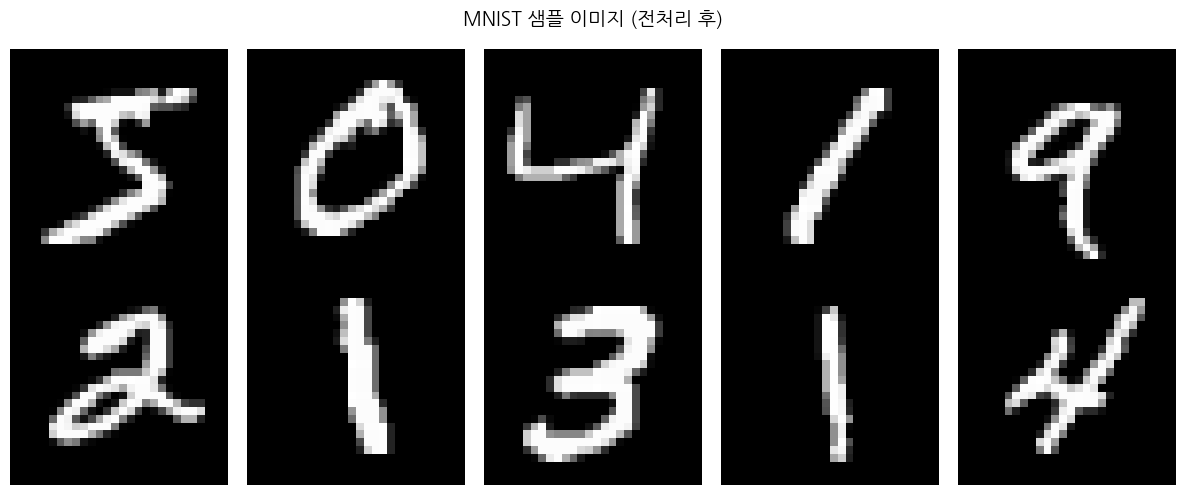

In [14]:
# 원본 이미지 몇 개 시각화
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    # [-1, 1] 범위를 [0, 1]로 변환하여 시각화
    img = (x_train[i].reshape(28, 28) + 1) / 2
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.suptitle("MNIST 샘플 이미지 (전처리 후)", fontsize=14)
plt.tight_layout()
plt.show()

## 🏗️ 1.2 Generator 네트워크 구축

### Generator 구조
```
입력: 노이즈 벡터 z (100차원)
  ↓
Dense(128) + ReLU
  ↓
Dense(256) + ReLU
  ↓
Dense(512) + ReLU
  ↓
Dense(784) + Tanh
  ↓
출력: 가짜 이미지 (784차원, [-1, 1] 범위)
```

**핵심 포인트**:
- 입력: 100차원 노이즈 (표준정규분포에서 샘플링)
- 점진적으로 차원 증가: 100 → 128 → 256 → 512 → 784
- 활성화 함수: ReLU (은닉층), Tanh (출력층)
- Tanh 사용 이유: 출력 범위 [-1, 1]로 데이터 범위와 일치

In [18]:
def build_generator():
    """
    Generator 네트워크 생성

    입력: z (batch_size, 100) - 노이즈 벡터
    출력: fake_images (batch_size, 784) - 생성된 가짜 이미지
    """
    model = tf.keras.Sequential(
        [
            # 첫 번째 층: 100 → 128
            # input_shape=(100,): 입력이 100차원 벡터임을 명시
            layers.Dense(128, activation="relu", input_shape=(100,)),
            # 두 번째 층: 128 → 256
            layers.Dense(256, activation="relu"),
            # 세 번째 층: 256 → 512
            layers.Dense(512, activation="relu"),
            # 출력층: 512 → 784
            # activation="tanh": 출력 범위 [-1, 1]
            # 784 = 28 × 28 (MNIST 이미지 크기)
            layers.Dense(784, activation="tanh"),
        ],
        name="Generator",
    )

    return model


# Generator 생성
generator = build_generator()
generator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,728 (2.21 MB)

 Trainable params: 579,728 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

### 🧪 Generator 테스트

랜덤 노이즈를 넣어서 출력을 확인해봅시다.

입력 노이즈 shape: (5, 100)
입력 노이즈 예시 (첫 10개 값): [ 0.3274685  -0.8426258   0.3194337  -1.4075519  -2.3880599  -1.0392479
 -0.5573232   0.539707    1.6994323   0.28893656]

출력 이미지 shape: (5, 784)
출력 값 범위: [-0.69, 0.67]


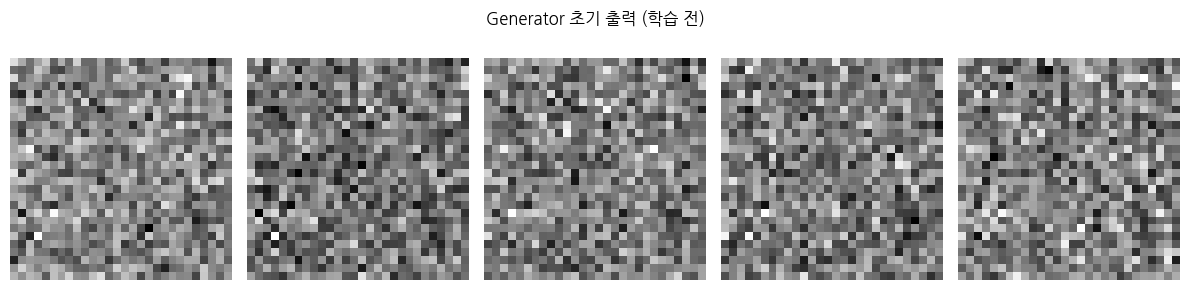

In [19]:
# 테스트: 랜덤 노이즈 생성 및 출력 확인
test_noise = tf.random.normal([5, 100])  # 5개의 노이즈 샘플
print(f"입력 노이즈 shape: {test_noise.shape}")
print(f"입력 노이즈 예시 (첫 10개 값): {test_noise[0, :10].numpy()}")

# Generator에 통과
test_output = generator(test_noise, training=False)
print(f"\n출력 이미지 shape: {test_output.shape}")
print(
    f"출력 값 범위: [{test_output.numpy().min():.2f}, {test_output.numpy().max():.2f}]"
)

# 생성된 이미지 시각화 (학습 전이라 노이즈처럼 보임)
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes):
    img = test_output[i].numpy().reshape(28, 28)
    img = (img + 1) / 2  # [-1,1] → [0,1]
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.suptitle("Generator 초기 출력 (학습 전)", fontsize=12)
plt.tight_layout()
plt.show()

## 🏗️ 1.3 Discriminator 네트워크 구축

### Discriminator 구조
```
입력: 이미지 (784차원)
  ↓
Dense(512) + ReLU
  ↓
Dense(256) + ReLU
  ↓
Dense(1) + Sigmoid
  ↓
출력: 진짜일 확률 (0~1 사이 스칼라)
```

**핵심 포인트**:
- 입력: 784차원 이미지
- 점진적으로 차원 감소: 784 → 512 → 256 → 1
- 활성화 함수: ReLU (은닉층), Sigmoid (출력층)
- Sigmoid 사용 이유: 출력을 [0, 1] 확률로 해석

In [20]:
def build_discriminator():
    """
    Discriminator 네트워크 생성

    입력: images (batch_size, 784) - 진짜 또는 가짜 이미지
    출력: predictions (batch_size, 1) - 진짜일 확률 [0, 1]
    """
    model = tf.keras.Sequential(
        [
            # 첫 번째 층: 784 → 512
            # input_shape=(784,): 입력이 784차원 벡터(flatten된 이미지)
            layers.Dense(512, activation="relu", input_shape=(784,)),
            # 두 번째 층: 512 → 256
            layers.Dense(256, activation="relu"),
            # 출력층: 256 → 1
            # activation="sigmoid": 출력을 0~1 사이의 확률로 변환
            # 출력 해석:
            #   - 1에 가까움: 진짜일 확률 높음
            #   - 0에 가까움: 가짜일 확률 높음
            layers.Dense(1, activation="sigmoid"),
        ],
        name="Discriminator",
    )

    return model


# Discriminator 생성
discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

### 🧪 Discriminator 테스트

진짜 이미지와 가짜 이미지를 넣어서 구별을 잘 하는지 확인해봅시다.

In [8]:
# 테스트 1: 진짜 이미지
real_test = x_train[:5]  # 실제 MNIST 이미지 5개
real_pred = discriminator(real_test, training=False)
print("진짜 이미지에 대한 판별 결과:")
print(f"Shape: {real_pred.shape}")
print(f"예측값: {real_pred.numpy().flatten()}")
print(f"해석: 초기 상태이므로 랜덤 값 (학습 후에는 1에 가까워져야 함)")

# 테스트 2: Generator가 만든 가짜 이미지
fake_test = generator(tf.random.normal([5, 100]), training=False)
fake_pred = discriminator(fake_test, training=False)
print("\n가짜 이미지에 대한 판별 결과:")
print(f"Shape: {fake_pred.shape}")
print(f"예측값: {fake_pred.numpy().flatten()}")
print(f"해석: 초기 상태이므로 랜덤 값 (학습 후에는 0에 가까워져야 함)")

진짜 이미지에 대한 판별 결과:
Shape: (5, 1)
예측값: [0.6363372  0.6362011  0.5768138  0.68488914 0.60323155]
해석: 초기 상태이므로 랜덤 값 (학습 후에는 1에 가까워져야 함)

가짜 이미지에 대한 판별 결과:
Shape: (5, 1)
예측값: [0.5214256  0.48914438 0.46905333 0.48996344 0.52407175]
해석: 초기 상태이므로 랜덤 값 (학습 후에는 0에 가까워져야 함)


## ⚙️ 1.4 손실 함수와 옵티마이저 설정

### Binary Cross Entropy (BCE)

GAN에서는 BCE를 사용합니다:

$$
\text{BCE}(y, \hat{y}) = -\frac{1}{m}\sum_{i=1}^{m}[y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)]
$$

- $y$: 실제 레이블 (0 또는 1)
- $\hat{y}$: 모델 예측 확률 (0~1 사이)

### Adam Optimizer

- Learning rate: 0.0002 (GAN에서 일반적으로 사용)
- β1: 0.9 (기본값, 일부 논문에서는 0.5 권장)
- β2: 0.999 (기본값)

In [21]:
# Binary Cross Entropy Loss
# from_logits=False: Discriminator의 출력이 이미 sigmoid를 거친 확률값
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Optimizer 설정
# Generator와 Discriminator는 독립적으로 학습되므로 각각 optimizer 필요
optimizer_g = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_d = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

print("✅ 손실 함수: Binary Cross Entropy")
print("✅ Optimizer: Adam (lr=0.0002, β1=0.5)")

✅ 손실 함수: Binary Cross Entropy
✅ Optimizer: Adam (lr=0.0002, β1=0.5)


## 🎯 1.5 학습 Step 함수 구현

이제 가장 핵심적인 부분인 **학습 step 함수**를 구현합니다.

### 학습 흐름
```
한 배치의 진짜 이미지 입력
  ↓
1. Discriminator 학습
  - 노이즈로 가짜 이미지 생성
  - 진짜 이미지 → D → loss (목표: 1)
  - 가짜 이미지 → D → loss (목표: 0)
  - D 파라미터 업데이트
  ↓
2. Generator 학습
  - 새로운 노이즈로 가짜 이미지 생성
  - 가짜 이미지 → D → loss (목표: 1, D를 속이기!)
  - G 파라미터 업데이트
```

In [22]:
@tf.function  # 그래프 모드로 컴파일하여 속도 향상
def train_step(real_images):
    """
    GAN의 한 스텝 학습

    Args:
        real_images: 진짜 이미지 배치 (batch_size, 784)

    Returns:
        d_loss: Discriminator loss (scalar)
        g_loss: Generator loss (scalar)
    """
    # 현재 배치 크기 (마지막 배치에서 다를 수 있음)
    batch_size = tf.shape(real_images)[0]

    # ----------------------------
    # 1. Discriminator 학습
    # ----------------------------
    # GradientTape: 자동 미분을 위한 컨텍스트
    # tape_d는 discriminator의 파라미터에 대한 gradient를 기록
    with tf.GradientTape() as tape_d:
        # Step 1: 랜덤 노이즈 생성
        # shape: (batch_size, 100)
        # 예시: batch_size=128 → (128, 100)
        # 각 값은 표준정규분포 N(0,1)에서 샘플링
        noise = tf.random.normal([batch_size, 100])

        # Step 2: Generator로 가짜 이미지 생성
        # fake_images shape: (batch_size, 784)
        # 값 범위: [-1, 1] (tanh 출력)
        fake_images = generator(noise, training=True)

        # Step 3: Discriminator에 진짜 이미지 통과
        # real_output shape: (batch_size, 1)
        # 각 값은 "진짜일 확률" (0~1 사이)
        # 예시: [[0.85], [0.62], [0.91], ...]
        real_output = discriminator(real_images, training=True)

        # Step 4: Discriminator에 가짜 이미지 통과
        # fake_output shape: (batch_size, 1)
        # 각 값은 "진짜일 확률" (0~1 사이)
        # 예시: [[0.04], [0.15], [0.01], ...]
        fake_output = discriminator(fake_images, training=True)

        # Step 5: Discriminator Loss 계산
        # (1) 진짜 이미지에 대한 loss
        # 목표: D(real) → 1 (진짜를 진짜로 판단)
        # tf.ones_like(real_output): 모든 값이 1인 텐서 생성
        # BCE(target=1, prediction=real_output)
        # 예시: BCE(1, 0.85) = -log(0.85) = 0.162
        d_loss_real = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)

        # (2) 가짜 이미지에 대한 loss
        # 목표: D(fake) → 0 (가짜를 가짜로 판단)
        # tf.zeros_like(fake_output): 모든 값이 0인 텐서 생성
        # BCE(target=0, prediction=fake_output)
        # 예시: BCE(0, 0.04) = -log(1-0.04) = 0.0408
        d_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)

        # (3) 총 Discriminator loss
        # d_loss = 진짜 loss + 가짜 loss
        # 예시: 0.162 + 0.0408 = 0.2028
        d_loss = d_loss_real + d_loss_fake

    # Step 6: Discriminator Gradient 계산 및 업데이트
    # gradient 계산: loss를 D의 파라미터로 미분
    grads_d = tape_d.gradient(d_loss, discriminator.trainable_variables)
    # gradient 적용: θ_D ← θ_D - η∇L_D
    optimizer_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    # ----------------------------
    # 2. Generator 학습
    # ----------------------------
    # 새로운 GradientTape (G의 파라미터에 대한 gradient 기록)
    with tf.GradientTape() as tape_g:
        # Step 1: 새로운 노이즈 생성
        # 이유: D 학습 때 사용한 noise는 이미 detach됨
        # 새로운 noise로 G가 다양한 이미지를 생성하도록 유도
        noise = tf.random.normal([batch_size, 100])

        # Step 2: Generator로 가짜 이미지 생성
        # fake_images shape: (batch_size, 784)
        fake_images = generator(noise, training=True)

        # Step 3: Discriminator에 통과
        # fake_output shape: (batch_size, 1)
        # 예시: [[0.12], [0.07], [0.03], ...]
        fake_output = discriminator(fake_images, training=True)

        # Step 4: Generator Loss 계산
        # 목표: D(G(z)) → 1 (Discriminator를 속이기!)
        # 주의: 여기서 target은 1 (ones_like)
        # G는 "가짜 이미지를 진짜로 착각시키고 싶음"
        # BCE(target=1, prediction=fake_output)
        # 예시: BCE(1, 0.12) = -log(0.12) = 2.120
        g_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # Step 5: Generator Gradient 계산 및 업데이트
    # gradient 계산: loss를 G의 파라미터로 미분
    grads_g = tape_g.gradient(g_loss, generator.trainable_variables)
    # gradient 적용: θ_G ← θ_G - η∇L_G
    optimizer_g.apply_gradients(zip(grads_g, generator.trainable_variables))

    # Loss 반환 (모니터링용)
    return d_loss, g_loss


print("✅ train_step 함수 정의 완료")

✅ train_step 함수 정의 완료


## 📊 1.6 생성 이미지 시각화 함수

In [24]:
def generate_and_save(epoch, model, seed):
    """
    Generator로 이미지를 생성하고 시각화

    Args:
        epoch: 현재 에폭 번호
        model: Generator 모델
        seed: 고정된 노이즈 시드 (일관된 비교를 위해)
    """
    # Generator로 이미지 생성
    # predictions shape: (16, 784)
    predictions = model(seed, training=False)

    # numpy 배열로 변환 및 reshape
    # (16, 784) → (16, 28, 28)
    predictions = predictions.numpy().reshape(-1, 28, 28)

    # 4×4 그리드로 시각화
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        # [-1, 1] → [0, 1] 변환하여 시각화
        plt.imshow((predictions[i] + 1) / 2, cmap="gray")
        plt.axis("off")

    plt.suptitle(f"Epoch {epoch}", fontsize=16)
    plt.tight_layout()
    plt.show()


print("✅ generate_and_save 함수 정의 완료")

✅ generate_and_save 함수 정의 완료


## 🚀 1.7 전체 학습 루프

드디어 모든 준비가 끝났습니다! 이제 GAN을 학습시켜봅시다.

### 학습 과정
- 총 50 에폭 학습
- 10 에폭마다 생성 이미지 확인
- 고정된 노이즈(seed)로 일관된 비교 가능

🔥 학습 시작!
총 에폭: 200
배치 크기: 128
배치당 이미지 수: 128
총 학습 스텝: 93800

🔥 Epoch 1/200
  Batch 100/469 - D Loss: 0.6412, G Loss: 2.5459
  Batch 200/469 - D Loss: 0.6943, G Loss: 2.2226
  Batch 300/469 - D Loss: 0.6595, G Loss: 2.1362
  Batch 400/469 - D Loss: 0.6606, G Loss: 2.3731
  📊 Epoch 1 평균 - D Loss: 0.7673, G Loss: 2.3357
  🎨 생성 이미지 시각화 중...


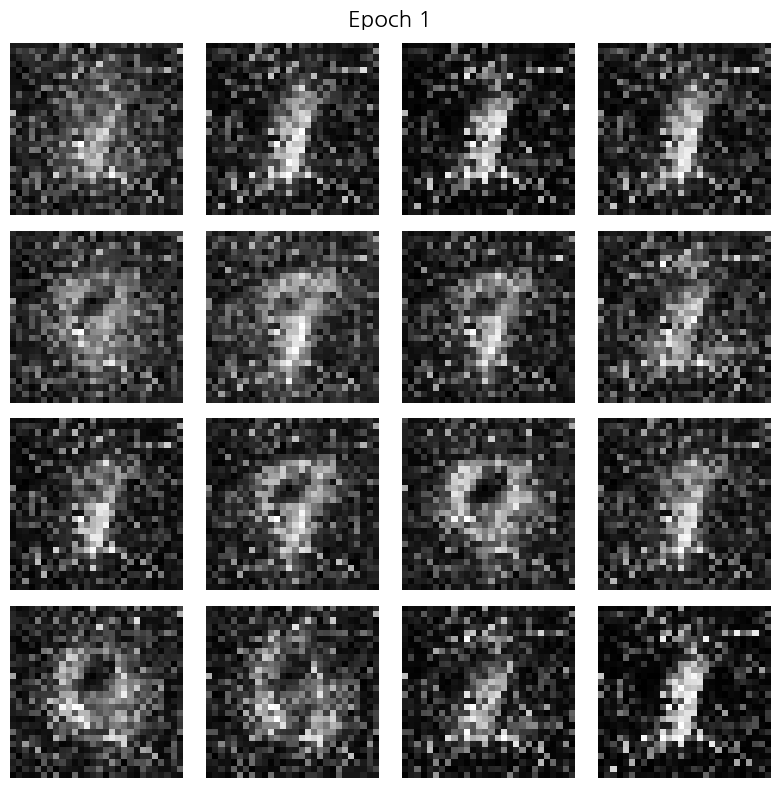


🔥 Epoch 2/200
  Batch 100/469 - D Loss: 0.6726, G Loss: 2.7041
  Batch 200/469 - D Loss: 0.7288, G Loss: 3.1994
  Batch 300/469 - D Loss: 0.6789, G Loss: 2.6115
  Batch 400/469 - D Loss: 0.6815, G Loss: 2.7486
  📊 Epoch 2 평균 - D Loss: 0.7589, G Loss: 2.4578

🔥 Epoch 3/200
  Batch 100/469 - D Loss: 0.8785, G Loss: 3.1534
  Batch 200/469 - D Loss: 0.7073, G Loss: 2.3963
  Batch 300/469 - D Loss: 1.1770, G Loss: 1.1837
  Batch 400/469 - D Loss: 0.8055, G Loss: 2.5228
  📊 Epoch 3 평균 - D Loss: 0.7493, G Loss: 2.5365

🔥 Epoch 4/200
  Batch 100/469 - D Loss: 0.7099, G Loss: 3.0433
  Batch 200/469 - D Loss: 0.7709, G Loss: 2.3561
  Batch 300/469 - D Loss: 0.6478, G Loss: 3.0638
  Batch 400/469 - D Loss: 0.6975, G Loss: 2.6461
  📊 Epoch 4 평균 - D Loss: 0.7338, G Loss: 2.4886

🔥 Epoch 5/200
  Batch 100/469 - D Loss: 0.7464, G Loss: 2.3703
  Batch 200/469 - D Loss: 0.7939, G Loss: 2.0266
  Batch 300/469 - D Loss: 0.9745, G Loss: 1.9510
  Batch 400/469 - D Loss: 0.7340, G Loss: 2.1855
  📊 Epoch 5 

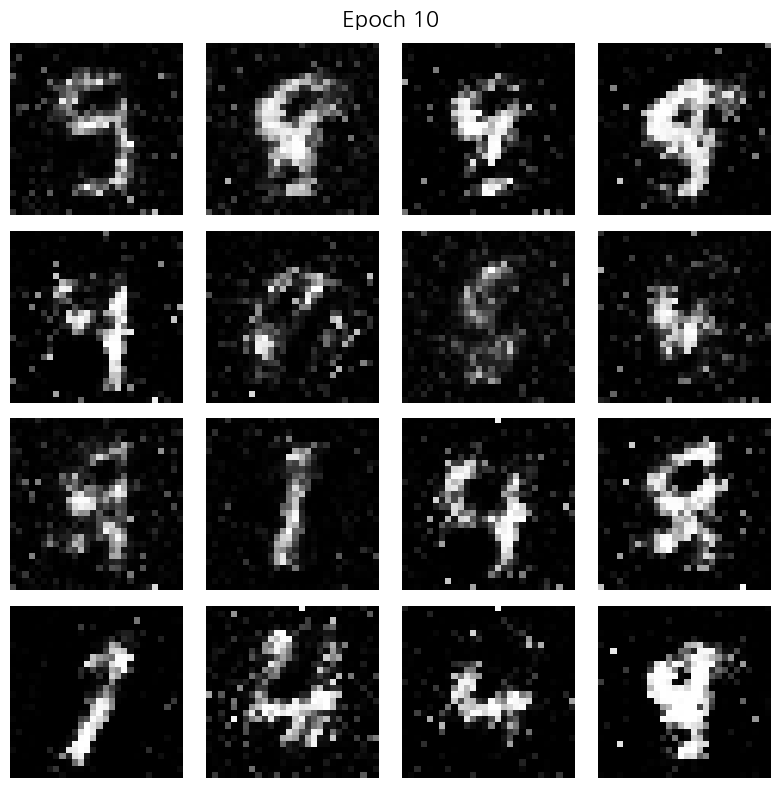


🔥 Epoch 11/200
  Batch 100/469 - D Loss: 0.8022, G Loss: 1.9906
  Batch 200/469 - D Loss: 0.8377, G Loss: 1.6608
  Batch 300/469 - D Loss: 0.9355, G Loss: 3.0317
  Batch 400/469 - D Loss: 0.9010, G Loss: 1.7904
  📊 Epoch 11 평균 - D Loss: 0.8555, G Loss: 1.9030

🔥 Epoch 12/200
  Batch 100/469 - D Loss: 0.8580, G Loss: 1.8216
  Batch 200/469 - D Loss: 0.9438, G Loss: 2.4138
  Batch 300/469 - D Loss: 0.8604, G Loss: 1.8207
  Batch 400/469 - D Loss: 0.8970, G Loss: 1.6262
  📊 Epoch 12 평균 - D Loss: 0.8679, G Loss: 1.8709

🔥 Epoch 13/200
  Batch 100/469 - D Loss: 0.8268, G Loss: 2.0798
  Batch 200/469 - D Loss: 0.8385, G Loss: 1.9615
  Batch 300/469 - D Loss: 0.9535, G Loss: 2.2190
  Batch 400/469 - D Loss: 0.8886, G Loss: 1.4846
  📊 Epoch 13 평균 - D Loss: 0.8864, G Loss: 1.8243

🔥 Epoch 14/200
  Batch 100/469 - D Loss: 0.8867, G Loss: 1.7445
  Batch 200/469 - D Loss: 0.9234, G Loss: 1.3763
  Batch 300/469 - D Loss: 0.8856, G Loss: 1.6994
  Batch 400/469 - D Loss: 0.8549, G Loss: 1.4293
  📊 E

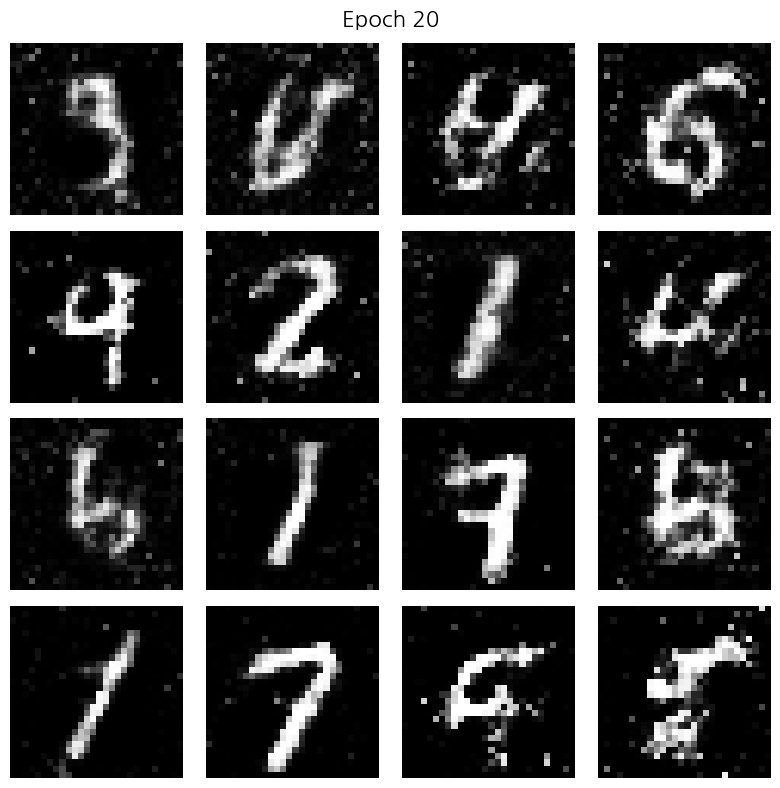


🔥 Epoch 21/200
  Batch 100/469 - D Loss: 0.8617, G Loss: 1.5830
  Batch 200/469 - D Loss: 0.9040, G Loss: 1.4731
  Batch 300/469 - D Loss: 0.9406, G Loss: 1.3393
  Batch 400/469 - D Loss: 1.0028, G Loss: 1.4153
  📊 Epoch 21 평균 - D Loss: 0.9447, G Loss: 1.6567

🔥 Epoch 22/200
  Batch 100/469 - D Loss: 0.8993, G Loss: 1.5743
  Batch 200/469 - D Loss: 0.8742, G Loss: 1.6008
  Batch 300/469 - D Loss: 0.9272, G Loss: 1.8259
  Batch 400/469 - D Loss: 0.9582, G Loss: 2.0542
  📊 Epoch 22 평균 - D Loss: 0.9457, G Loss: 1.6585

🔥 Epoch 23/200
  Batch 100/469 - D Loss: 0.9239, G Loss: 2.0010
  Batch 200/469 - D Loss: 0.9804, G Loss: 1.5432
  Batch 300/469 - D Loss: 0.8824, G Loss: 1.7384
  Batch 400/469 - D Loss: 0.9541, G Loss: 1.8526
  📊 Epoch 23 평균 - D Loss: 0.9413, G Loss: 1.6959

🔥 Epoch 24/200
  Batch 100/469 - D Loss: 0.9351, G Loss: 1.5065
  Batch 200/469 - D Loss: 1.1088, G Loss: 1.1919
  Batch 300/469 - D Loss: 0.9814, G Loss: 1.4224
  Batch 400/469 - D Loss: 0.8759, G Loss: 1.4412
  📊 E

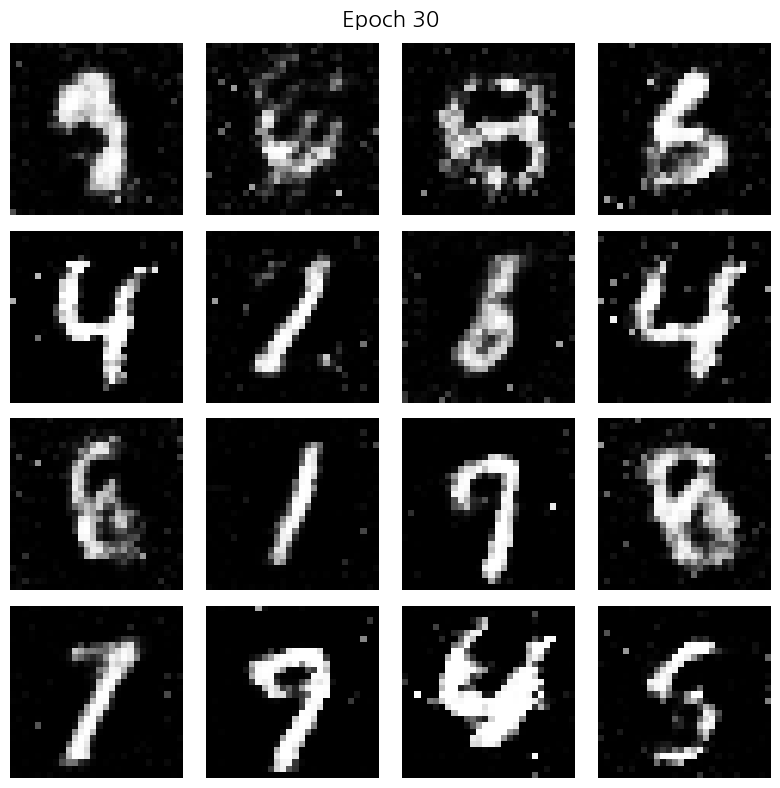


🔥 Epoch 31/200
  Batch 100/469 - D Loss: 0.9307, G Loss: 1.7223
  Batch 200/469 - D Loss: 0.8917, G Loss: 1.8018
  Batch 300/469 - D Loss: 1.0216, G Loss: 1.4785
  Batch 400/469 - D Loss: 0.9752, G Loss: 1.4350
  📊 Epoch 31 평균 - D Loss: 0.9598, G Loss: 1.6444

🔥 Epoch 32/200
  Batch 100/469 - D Loss: 1.0067, G Loss: 1.5248
  Batch 200/469 - D Loss: 0.9944, G Loss: 1.4439
  Batch 300/469 - D Loss: 1.0130, G Loss: 1.9526
  Batch 400/469 - D Loss: 0.9217, G Loss: 1.6807
  📊 Epoch 32 평균 - D Loss: 0.9616, G Loss: 1.6324

🔥 Epoch 33/200
  Batch 100/469 - D Loss: 0.9509, G Loss: 1.5685
  Batch 200/469 - D Loss: 0.9708, G Loss: 2.0245
  Batch 300/469 - D Loss: 0.9909, G Loss: 1.5034
  Batch 400/469 - D Loss: 0.9672, G Loss: 1.5011
  📊 Epoch 33 평균 - D Loss: 0.9650, G Loss: 1.6246

🔥 Epoch 34/200
  Batch 100/469 - D Loss: 0.9807, G Loss: 1.5738
  Batch 200/469 - D Loss: 0.9701, G Loss: 2.0432
  Batch 300/469 - D Loss: 0.9452, G Loss: 1.4391
  Batch 400/469 - D Loss: 0.9730, G Loss: 1.7318
  📊 E

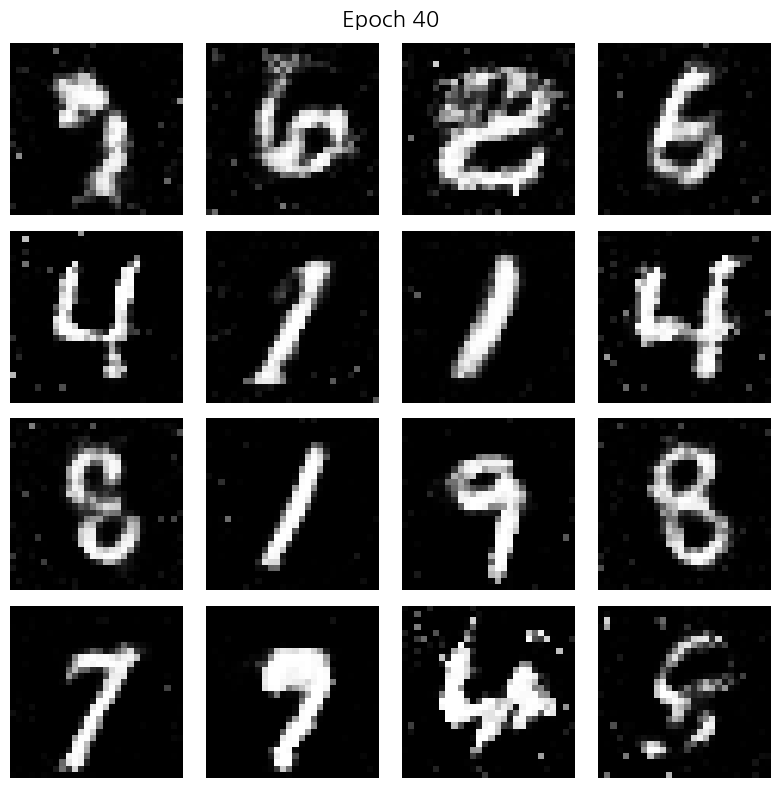


🔥 Epoch 41/200
  Batch 100/469 - D Loss: 0.9343, G Loss: 1.5095
  Batch 200/469 - D Loss: 0.9248, G Loss: 1.7039
  Batch 300/469 - D Loss: 0.9438, G Loss: 1.4218
  Batch 400/469 - D Loss: 1.0015, G Loss: 1.5293
  📊 Epoch 41 평균 - D Loss: 0.9607, G Loss: 1.6279

🔥 Epoch 42/200
  Batch 100/469 - D Loss: 0.9504, G Loss: 1.5789
  Batch 200/469 - D Loss: 0.9798, G Loss: 1.4000
  Batch 300/469 - D Loss: 1.0188, G Loss: 1.7300
  Batch 400/469 - D Loss: 0.9238, G Loss: 1.5261
  📊 Epoch 42 평균 - D Loss: 0.9684, G Loss: 1.6196

🔥 Epoch 43/200
  Batch 100/469 - D Loss: 0.9568, G Loss: 1.4459
  Batch 200/469 - D Loss: 0.9974, G Loss: 1.7738
  Batch 300/469 - D Loss: 0.9879, G Loss: 1.3875
  Batch 400/469 - D Loss: 1.0625, G Loss: 1.4892
  📊 Epoch 43 평균 - D Loss: 0.9636, G Loss: 1.6186

🔥 Epoch 44/200
  Batch 100/469 - D Loss: 0.8935, G Loss: 1.8578
  Batch 200/469 - D Loss: 0.9674, G Loss: 1.7188
  Batch 300/469 - D Loss: 1.0538, G Loss: 1.7482
  Batch 400/469 - D Loss: 1.0434, G Loss: 1.8299
  📊 E

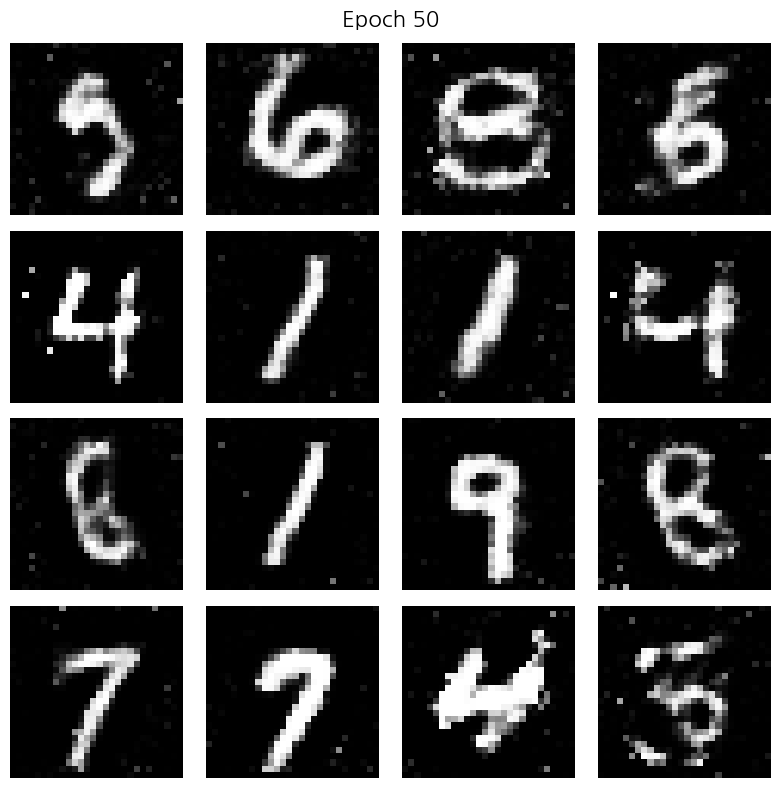


🔥 Epoch 51/200
  Batch 100/469 - D Loss: 0.9082, G Loss: 1.8545
  Batch 200/469 - D Loss: 0.9038, G Loss: 1.5290
  Batch 300/469 - D Loss: 0.9740, G Loss: 1.6803
  Batch 400/469 - D Loss: 0.9718, G Loss: 1.9597
  📊 Epoch 51 평균 - D Loss: 0.9630, G Loss: 1.6332

🔥 Epoch 52/200
  Batch 100/469 - D Loss: 0.9646, G Loss: 1.6425
  Batch 200/469 - D Loss: 1.0939, G Loss: 1.9220
  Batch 300/469 - D Loss: 0.9247, G Loss: 1.9688
  Batch 400/469 - D Loss: 0.9972, G Loss: 1.7392
  📊 Epoch 52 평균 - D Loss: 0.9582, G Loss: 1.6391

🔥 Epoch 53/200
  Batch 100/469 - D Loss: 0.9600, G Loss: 1.7826
  Batch 200/469 - D Loss: 0.9907, G Loss: 1.9674
  Batch 300/469 - D Loss: 0.9599, G Loss: 2.1809
  Batch 400/469 - D Loss: 0.9311, G Loss: 1.7350
  📊 Epoch 53 평균 - D Loss: 0.9579, G Loss: 1.6484

🔥 Epoch 54/200
  Batch 100/469 - D Loss: 0.9707, G Loss: 1.7787
  Batch 200/469 - D Loss: 1.0007, G Loss: 1.6725
  Batch 300/469 - D Loss: 0.9519, G Loss: 1.6459
  Batch 400/469 - D Loss: 0.8903, G Loss: 1.5818
  📊 E

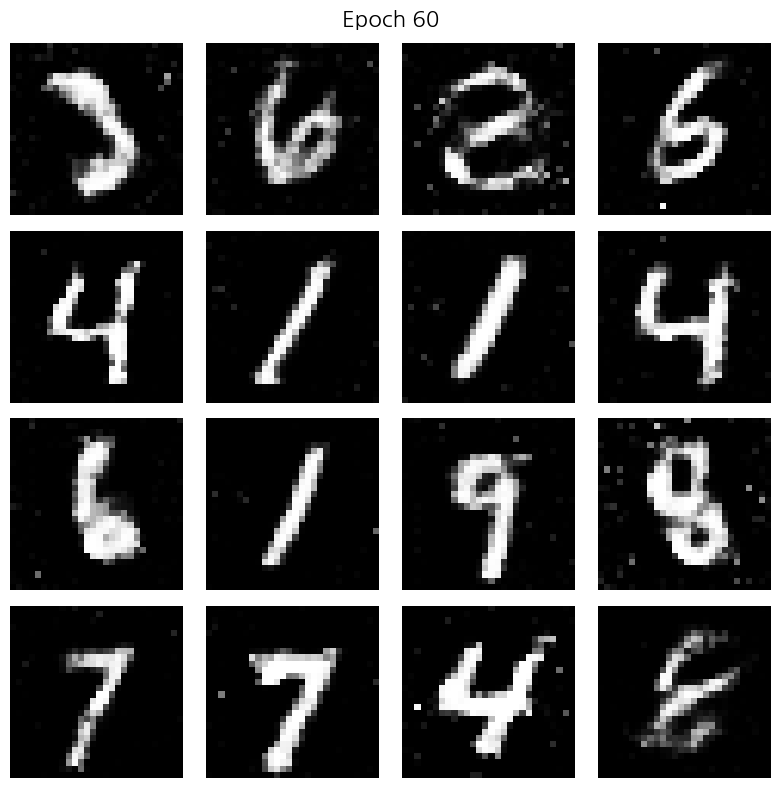


🔥 Epoch 61/200
  Batch 100/469 - D Loss: 0.9514, G Loss: 1.5052
  Batch 200/469 - D Loss: 1.0270, G Loss: 1.5481
  Batch 300/469 - D Loss: 0.8851, G Loss: 1.4833
  Batch 400/469 - D Loss: 0.8342, G Loss: 2.2943
  📊 Epoch 61 평균 - D Loss: 0.9530, G Loss: 1.6584

🔥 Epoch 62/200
  Batch 100/469 - D Loss: 1.0061, G Loss: 1.4614
  Batch 200/469 - D Loss: 0.8857, G Loss: 1.7150
  Batch 300/469 - D Loss: 0.9276, G Loss: 1.6976
  Batch 400/469 - D Loss: 0.9576, G Loss: 1.6431
  📊 Epoch 62 평균 - D Loss: 0.9575, G Loss: 1.6520

🔥 Epoch 63/200
  Batch 100/469 - D Loss: 1.0167, G Loss: 1.8679
  Batch 200/469 - D Loss: 0.9519, G Loss: 1.5474
  Batch 300/469 - D Loss: 0.9234, G Loss: 1.7807
  Batch 400/469 - D Loss: 0.9583, G Loss: 1.3843
  📊 Epoch 63 평균 - D Loss: 0.9533, G Loss: 1.6528

🔥 Epoch 64/200
  Batch 100/469 - D Loss: 0.9277, G Loss: 1.7205
  Batch 200/469 - D Loss: 0.9711, G Loss: 1.5836
  Batch 300/469 - D Loss: 1.0384, G Loss: 1.3798
  Batch 400/469 - D Loss: 1.1045, G Loss: 1.4420
  📊 E

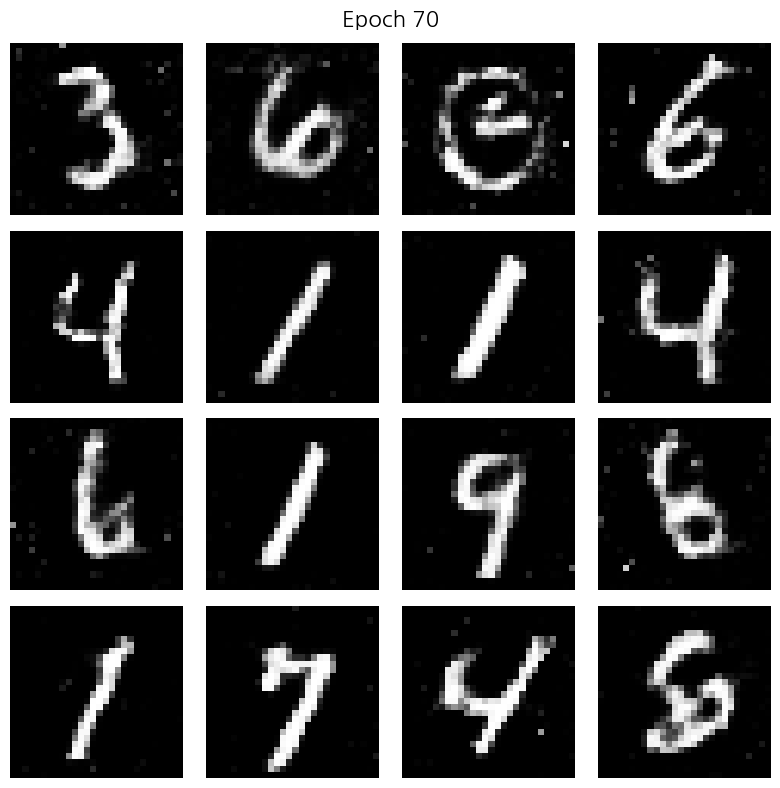


🔥 Epoch 71/200
  Batch 100/469 - D Loss: 0.9505, G Loss: 1.6944
  Batch 200/469 - D Loss: 0.9287, G Loss: 1.6483
  Batch 300/469 - D Loss: 0.9745, G Loss: 1.4004
  Batch 400/469 - D Loss: 0.9943, G Loss: 1.4483
  📊 Epoch 71 평균 - D Loss: 0.9566, G Loss: 1.6491

🔥 Epoch 72/200
  Batch 100/469 - D Loss: 0.9226, G Loss: 1.7179
  Batch 200/469 - D Loss: 0.9226, G Loss: 1.6775
  Batch 300/469 - D Loss: 0.9738, G Loss: 1.3250
  Batch 400/469 - D Loss: 1.0270, G Loss: 1.4373
  📊 Epoch 72 평균 - D Loss: 0.9485, G Loss: 1.6722

🔥 Epoch 73/200
  Batch 100/469 - D Loss: 0.9095, G Loss: 1.7073
  Batch 200/469 - D Loss: 0.9482, G Loss: 1.7340
  Batch 300/469 - D Loss: 0.8779, G Loss: 2.0080
  Batch 400/469 - D Loss: 0.8943, G Loss: 1.7612
  📊 Epoch 73 평균 - D Loss: 0.9507, G Loss: 1.6640

🔥 Epoch 74/200
  Batch 100/469 - D Loss: 0.8670, G Loss: 1.7357
  Batch 200/469 - D Loss: 0.9686, G Loss: 1.8055
  Batch 300/469 - D Loss: 0.8966, G Loss: 1.6069
  Batch 400/469 - D Loss: 0.9770, G Loss: 1.4486
  📊 E

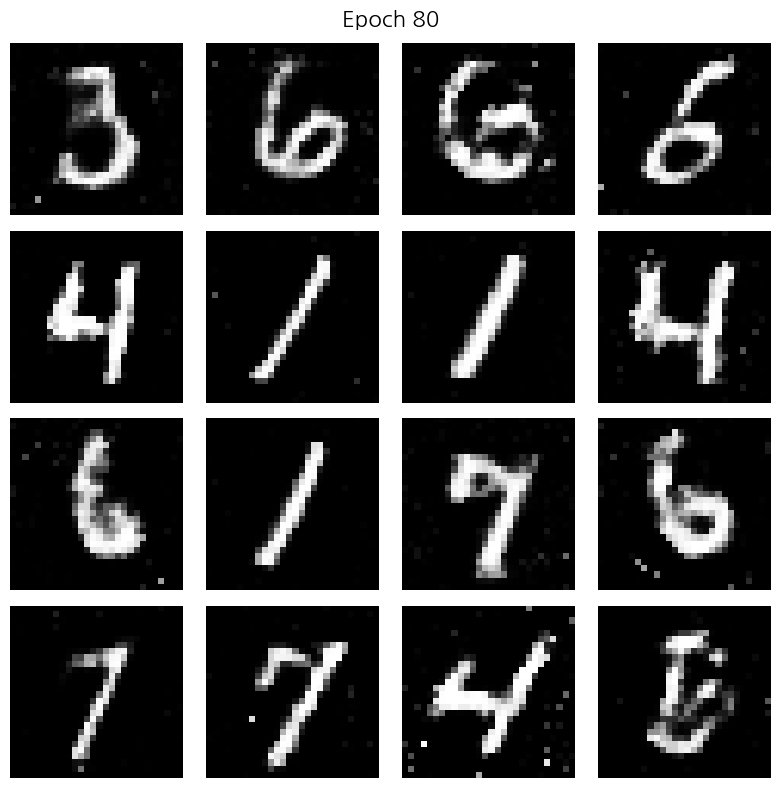


🔥 Epoch 81/200
  Batch 100/469 - D Loss: 0.8626, G Loss: 1.7530
  Batch 200/469 - D Loss: 0.9929, G Loss: 1.6319
  Batch 300/469 - D Loss: 0.9577, G Loss: 1.5964
  Batch 400/469 - D Loss: 0.8858, G Loss: 1.7722
  📊 Epoch 81 평균 - D Loss: 0.9505, G Loss: 1.6634

🔥 Epoch 82/200
  Batch 100/469 - D Loss: 0.9165, G Loss: 1.7206
  Batch 200/469 - D Loss: 0.8551, G Loss: 1.6008
  Batch 300/469 - D Loss: 0.9204, G Loss: 1.5955
  Batch 400/469 - D Loss: 0.9154, G Loss: 1.7067
  📊 Epoch 82 평균 - D Loss: 0.9511, G Loss: 1.6542

🔥 Epoch 83/200
  Batch 100/469 - D Loss: 1.0060, G Loss: 1.6787
  Batch 200/469 - D Loss: 0.9745, G Loss: 1.5264
  Batch 300/469 - D Loss: 0.9740, G Loss: 1.3790
  Batch 400/469 - D Loss: 0.9821, G Loss: 1.7974
  📊 Epoch 83 평균 - D Loss: 0.9541, G Loss: 1.6554

🔥 Epoch 84/200
  Batch 100/469 - D Loss: 0.9470, G Loss: 1.6598
  Batch 200/469 - D Loss: 0.9147, G Loss: 1.3816
  Batch 300/469 - D Loss: 0.9980, G Loss: 1.4333
  Batch 400/469 - D Loss: 0.9427, G Loss: 1.5631
  📊 E

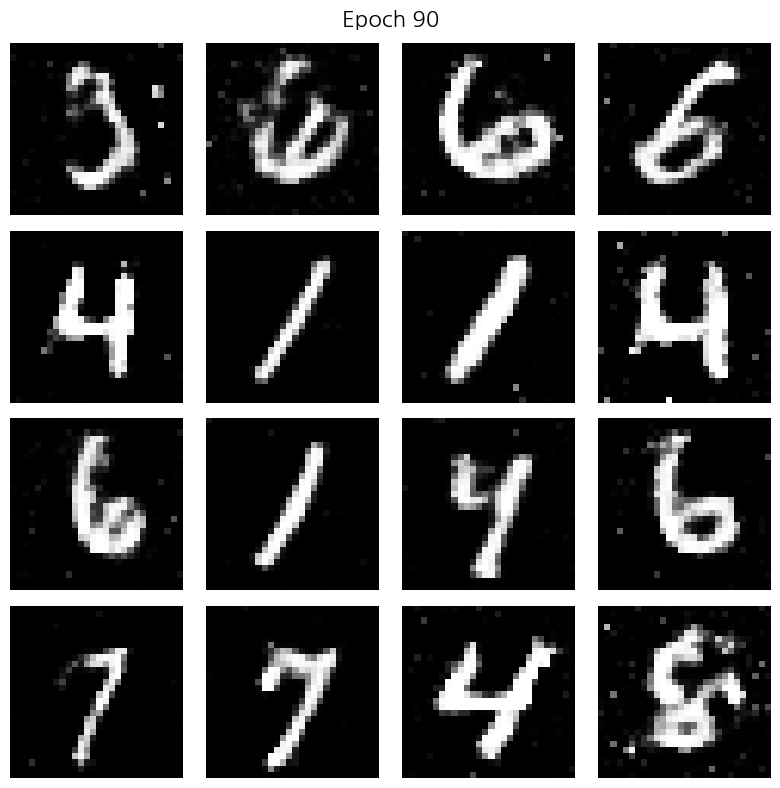


🔥 Epoch 91/200
  Batch 100/469 - D Loss: 0.9283, G Loss: 1.9690
  Batch 200/469 - D Loss: 0.9723, G Loss: 1.6499
  Batch 300/469 - D Loss: 1.0177, G Loss: 1.4840
  Batch 400/469 - D Loss: 1.0168, G Loss: 1.5702
  📊 Epoch 91 평균 - D Loss: 0.9453, G Loss: 1.6805

🔥 Epoch 92/200
  Batch 100/469 - D Loss: 0.9106, G Loss: 1.5652
  Batch 200/469 - D Loss: 0.9322, G Loss: 1.5983
  Batch 300/469 - D Loss: 0.8820, G Loss: 1.5038
  Batch 400/469 - D Loss: 0.9879, G Loss: 2.1505
  📊 Epoch 92 평균 - D Loss: 0.9482, G Loss: 1.6711

🔥 Epoch 93/200
  Batch 100/469 - D Loss: 0.9849, G Loss: 1.4072
  Batch 200/469 - D Loss: 0.9885, G Loss: 1.5177
  Batch 300/469 - D Loss: 0.8672, G Loss: 1.5965
  Batch 400/469 - D Loss: 0.9469, G Loss: 1.5020
  📊 Epoch 93 평균 - D Loss: 0.9440, G Loss: 1.6772

🔥 Epoch 94/200
  Batch 100/469 - D Loss: 1.0210, G Loss: 1.8160
  Batch 200/469 - D Loss: 0.9591, G Loss: 1.5125
  Batch 300/469 - D Loss: 0.9676, G Loss: 1.7649
  Batch 400/469 - D Loss: 0.8976, G Loss: 1.5177
  📊 E

KeyboardInterrupt: 

In [25]:
# 학습 하이퍼파라미터
epochs = 200

# 고정된 노이즈 시드 생성 (에폭마다 동일한 노이즈로 비교)
# shape: (16, 100)
seed = tf.random.normal([16, 100])

print(f"🔥 학습 시작!")
print(f"총 에폭: {epochs}")
print(f"배치 크기: {batch_size}")
print(f"배치당 이미지 수: {batch_size}")
print(f"총 학습 스텝: {len(dataset) * epochs}")
print("=" * 50)

# 학습 루프
for epoch in range(1, epochs + 1):
    print(f"\n🔥 Epoch {epoch}/{epochs}")

    # 에폭 내 모든 배치에 대해 학습
    epoch_d_loss = []
    epoch_g_loss = []

    for batch_idx, real_batch in enumerate(dataset):
        # 한 스텝 학습
        d_loss, g_loss = train_step(real_batch)

        # Loss 기록
        epoch_d_loss.append(d_loss.numpy())
        epoch_g_loss.append(g_loss.numpy())

        # 중간 진행상황 출력 (100 배치마다)
        if (batch_idx + 1) % 100 == 0:
            print(
                f"  Batch {batch_idx + 1}/{len(dataset)} - "
                f"D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}"
            )

    # 에폭 평균 loss 계산
    avg_d_loss = np.mean(epoch_d_loss)
    avg_g_loss = np.mean(epoch_g_loss)

    print(
        f"  📊 Epoch {epoch} 평균 - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}"
    )

    # 10 에폭마다 생성 이미지 확인
    if epoch % 10 == 0 or epoch == 1:
        print(f"  🎨 생성 이미지 시각화 중...")
        generate_and_save(epoch, generator, seed)

print("\n✅ 학습 완료!")

### 📈 학습 결과 분석

학습이 잘 되었는지 확인해봅시다:

1. **Loss 값 확인**
   - D loss와 G loss가 균형있게 변화하는가?
   - Loss가 너무 0에 가깝지 않은가? (mode collapse 위험)
   - Loss가 발산하지 않는가?

2. **생성 이미지 품질**
   - Epoch 1: 노이즈처럼 보임
   - Epoch 10~20: 숫자의 윤곽이 보이기 시작
   - Epoch 30~50: 명확한 숫자 형태

3. **다양성**
   - 여러 가지 숫자가 생성되는가?
   - 한 가지 숫자만 반복되지 않는가? (mode collapse 체크)

## 🧪 1.8 최종 결과 확인 및 추가 테스트

🎨 다양한 노이즈로 이미지 생성 테스트


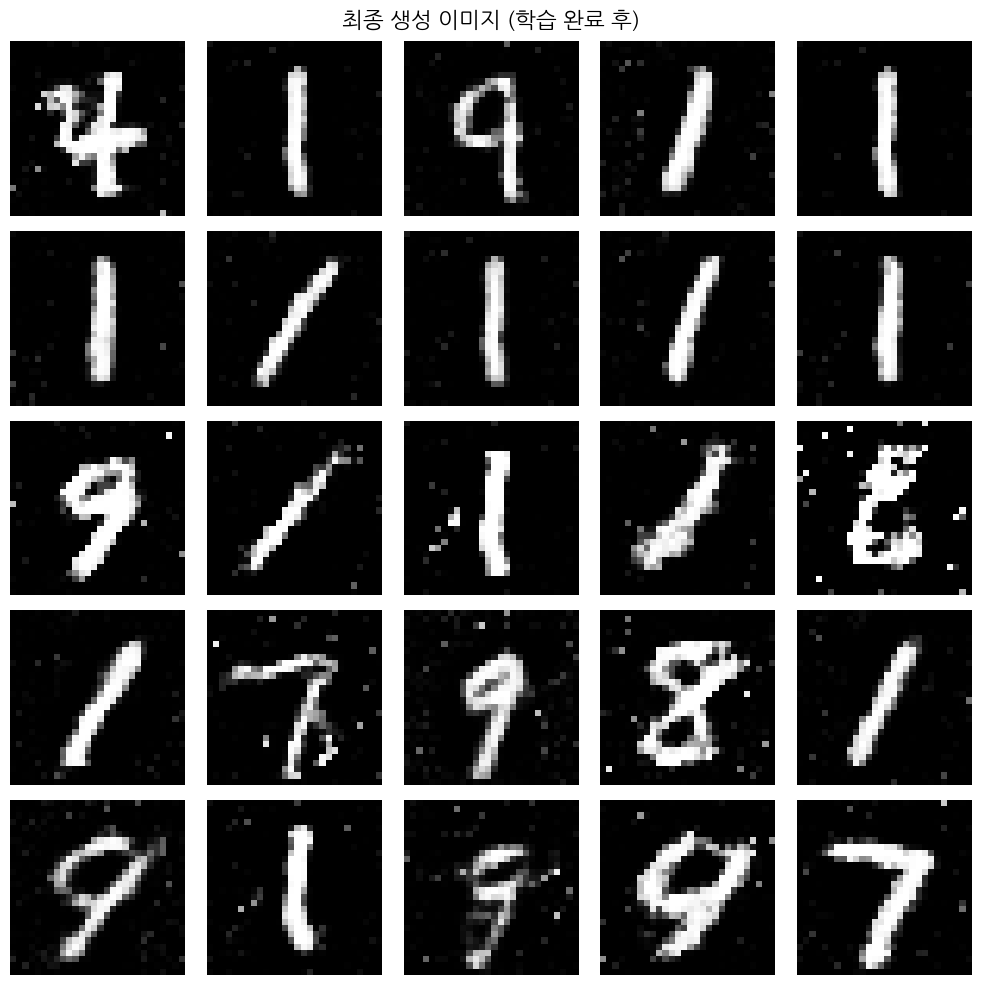

In [13]:
# 더 많은 이미지 생성해보기
print("🎨 다양한 노이즈로 이미지 생성 테스트")

num_samples = 25
test_noise = tf.random.normal([num_samples, 100])
generated_images = generator(test_noise, training=False)
generated_images = generated_images.numpy().reshape(-1, 28, 28)

plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow((generated_images[i] + 1) / 2, cmap="gray")
    plt.axis("off")
plt.suptitle("최종 생성 이미지 (학습 완료 후)", fontsize=16)
plt.tight_layout()
plt.show()

# 🔥 Part 2: PyTorch로 Vanilla GAN 구현

이제 동일한 GAN을 PyTorch로 구현해봅시다!

---

## 🔧 2.1 라이브러리 임포트 및 환경 설정

In [3]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# 디바이스 설정 (GPU 사용 가능 시 자동으로 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 디바이스: {device}")

# 랜덤 시드 설정 (재현성)
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)

# 하이퍼파라미터 설정
batch_size = 128  # 배치 크기
z_dim = 100  # 노이즈 벡터 차원
lr = 0.0002  # 학습률
epochs = 50  # 총 에폭 수

print(f"✅ 하이퍼파라미터 설정 완료")
print(f"  - Batch size: {batch_size}")
print(f"  - Noise dimension: {z_dim}")
print(f"  - Learning rate: {lr}")
print(f"  - Epochs: {epochs}")

사용 디바이스: cuda
✅ 하이퍼파라미터 설정 완료
  - Batch size: 128
  - Noise dimension: 100
  - Learning rate: 0.0002
  - Epochs: 50


## 📊 2.2 데이터 준비

### PyTorch vs TensorFlow 데이터 전처리 비교

**TensorFlow 방식:**
```python
x_train = (x_train - 127.5) / 127.5  # [0,255] → [-1,1]
```

**PyTorch 방식:**
```python
transforms.ToTensor()              # [0,255] → [0,1]
transforms.Normalize((0.5,), (0.5,))  # [0,1] → [-1,1]
```

두 방식 모두 최종 결과는 [-1, 1] 범위로 동일합니다.

In [4]:
#운영체제 확인
!cat /etc/issue

#0. CPU 정보 확인
!cat /proc/cpuinfo

#1. CPU 코어 전체 개수 확인
!grep -c processor /proc/cpuinfo

#2. 물리 CPU 수 확인
!grep "physical id" /proc/cpuinfo | sort -u | wc -l

# 3.CPU당 물리 코어 수 확인
!grep "cpu cores" /proc/cpuinfo | tail -1

#메모리 확인
!free -h

#런타임 유형 변경 후 gpu 확인
!nvidia-smi

12


In [7]:
# 데이터 전처리 파이프라인
# 1. ToTensor(): numpy array → torch.Tensor, [0,255] → [0,1]
# 2. Normalize((0.5,), (0.5,)): (x - 0.5) / 0.5로 [0,1] → [-1,1]
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # (H,W) → (1,H,W), [0,1]
        transforms.Normalize((0.5,), (0.5,)),  # [0,1] → [-1,1]
    ]
)

# MNIST 데이터셋 다운로드 및 로드
train_dataset = datasets.MNIST(
    root="./data",  # 데이터 저장 경로
    train=True,  # 학습 데이터 사용
    transform=transform,  # 전처리 적용
    download=True,  # 없으면 자동 다운로드
)

# DataLoader 생성 (배치 처리 및 셔플)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # 에폭마다 데이터 순서 섞기
    drop_last=True,  # 마지막 불완전한 배치 버리기
    num_workers=12,
    pin_memory=True
)

print(f"✅ 데이터 로드 완료")
print(f"  - 학습 샘플 수: {len(train_dataset)}")
print(f"  - 배치 수: {len(train_loader)}")
print(f"  - 이미지 shape: {train_dataset[0][0].shape}")

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]

✅ 데이터 로드 완료
  - 학습 샘플 수: 60000
  - 배치 수: 468
  - 이미지 shape: torch.Size([1, 28, 28])


### 🔍 데이터 시각화

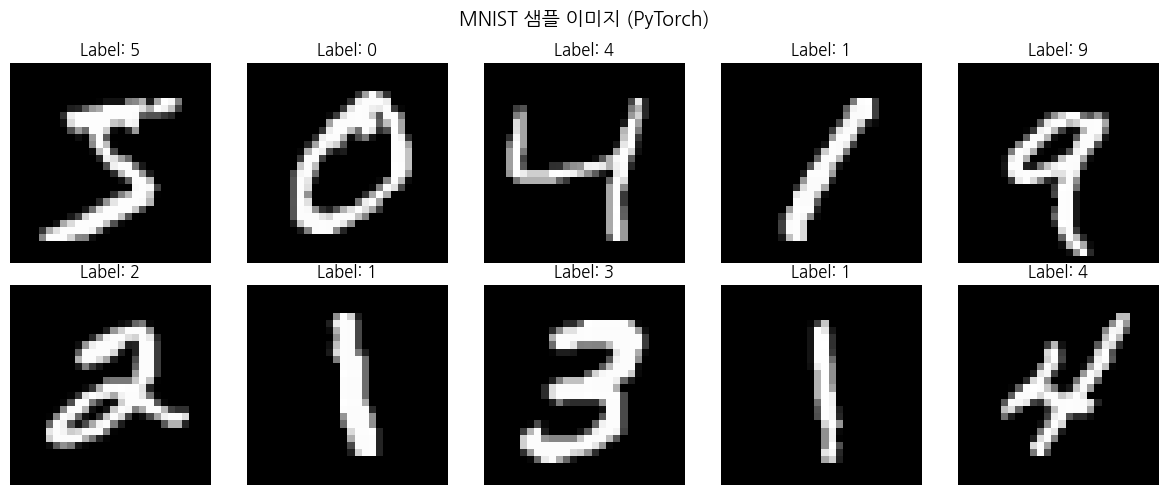

In [7]:
# 샘플 이미지 확인
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    # (1, 28, 28) → (28, 28)
    img = img.squeeze().numpy()
    # [-1, 1] → [0, 1]
    img = (img + 1) / 2
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.suptitle("MNIST 샘플 이미지 (PyTorch)", fontsize=14)
plt.tight_layout()
plt.show()

## 🏗️ 2.3 Generator 네트워크 정의

### PyTorch vs TensorFlow 네트워크 정의 비교

**TensorFlow (Sequential):**
```python
model = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    ...
])
```

**PyTorch (nn.Module):**
```python
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(...)
    def forward(self, x):
        return self.net(x)
```

In [8]:
class Generator(nn.Module):
    """
    Generator 네트워크

    구조:
        입력 (z_dim) → Dense(128) + ReLU
                     → Dense(256) + ReLU
                     → Dense(512) + ReLU
                     → Dense(784) + Tanh → 출력 (784)
    """

    def __init__(self, z_dim=100):
        super().__init__()

        # Sequential로 레이어 정의
        self.net = nn.Sequential(
            # 입력층: z_dim → 128
            # nn.Linear(in_features, out_features)
            nn.Linear(z_dim, 128),
            nn.ReLU(True),  # True: inplace 연산 (메모리 효율)
            # 은닉층 1: 128 → 256
            nn.Linear(128, 256),
            nn.ReLU(True),
            # 은닉층 2: 256 → 512
            nn.Linear(256, 512),
            nn.ReLU(True),
            # 출력층: 512 → 784
            nn.Linear(512, 784),
            nn.Tanh(),  # 출력 범위 [-1, 1]
        )

    def forward(self, z):
        """
        순전파

        Args:
            z: 노이즈 벡터 (batch_size, z_dim)

        Returns:
            fake_images: 생성된 이미지 (batch_size, 784)
        """
        return self.net(z)


# Generator 인스턴스 생성
generator = Generator(z_dim=z_dim).to(device)

print("✅ Generator 생성 완료")
print(generator)

✅ Generator 생성 완료
Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Tanh()
  )
)


### 🧪 Generator 테스트

입력 노이즈 shape: torch.Size([5, 100])
출력 이미지 shape: torch.Size([5, 784])
출력 값 범위: [-0.23, 0.19]


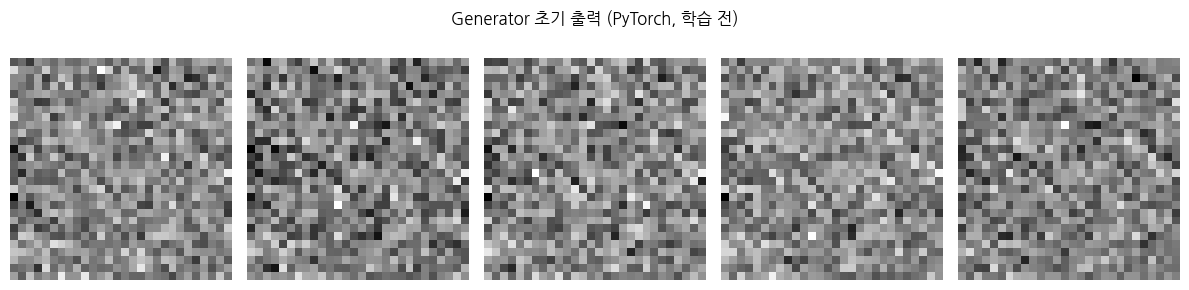

In [9]:
# 테스트: 랜덤 노이즈로 이미지 생성
with torch.no_grad():  # gradient 계산 비활성화 (테스트 시)
    test_noise = torch.randn(5, z_dim, device=device)
    test_output = generator(test_noise)

print(f"입력 노이즈 shape: {test_noise.shape}")
print(f"출력 이미지 shape: {test_output.shape}")
print(f"출력 값 범위: [{test_output.min().item():.2f}, {test_output.max().item():.2f}]")

# 시각화
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes):
    img = test_output[i].cpu().numpy().reshape(28, 28)
    img = (img + 1) / 2  # [-1,1] → [0,1]
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.suptitle("Generator 초기 출력 (PyTorch, 학습 전)", fontsize=12)
plt.tight_layout()
plt.show()

## 🏗️ 2.4 Discriminator 네트워크 정의

In [10]:
class Discriminator(nn.Module):
    """
    Discriminator 네트워크

    구조:
        입력 (784) → Dense(512) + ReLU
                   → Dense(256) + ReLU
                   → Dense(1) + Sigmoid → 출력 (1)
    """

    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            # 입력층: 784 → 512
            nn.Linear(784, 512),
            nn.ReLU(True),
            # 은닉층: 512 → 256
            nn.Linear(512, 256),
            nn.ReLU(True),
            # 출력층: 256 → 1
            nn.Linear(256, 1),
            nn.Sigmoid(),  # 출력 범위 [0, 1]
        )

    def forward(self, x):
        """
        순전파

        Args:
            x: 이미지 (batch_size, 784)

        Returns:
            predictions: 진짜일 확률 (batch_size, 1)
        """
        return self.net(x)


# Discriminator 인스턴스 생성
discriminator = Discriminator().to(device)

print("✅ Discriminator 생성 완료")
print(discriminator)

✅ Discriminator 생성 완료
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


### 🧪 Discriminator 테스트

In [11]:
# 테스트 1: 진짜 이미지
real_batch = next(iter(train_loader))[0][:5]  # 5개 샘플
real_batch = real_batch.view(-1, 784).to(device)

with torch.no_grad():
    real_pred = discriminator(real_batch)

print("진짜 이미지에 대한 판별:")
print(f"Shape: {real_pred.shape}")
print(f"예측값: {real_pred.squeeze().cpu().numpy()}")

# 테스트 2: 가짜 이미지
with torch.no_grad():
    fake_noise = torch.randn(5, z_dim, device=device)
    fake_batch = generator(fake_noise)
    fake_pred = discriminator(fake_batch)

print("\n가짜 이미지에 대한 판별:")
print(f"Shape: {fake_pred.shape}")
print(f"예측값: {fake_pred.squeeze().cpu().numpy()}")

진짜 이미지에 대한 판별:
Shape: torch.Size([5, 1])
예측값: [0.5116528  0.5231943  0.49453062 0.5292498  0.5068772 ]

가짜 이미지에 대한 판별:
Shape: torch.Size([5, 1])
예측값: [0.5037894  0.5029712  0.50372523 0.5043529  0.50300515]


## ⚙️ 2.5 손실 함수와 옵티마이저 설정

### PyTorch vs TensorFlow Loss 비교

**TensorFlow:**
```python
cross_entropy = tf.keras.losses.BinaryCrossentropy()
loss = cross_entropy(labels, predictions)
```

**PyTorch:**
```python
criterion = nn.BCELoss()
loss = criterion(predictions, labels)
```

주의: PyTorch는 (predictions, labels) 순서!

In [20]:
def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)
    if m.bias is not None:
      nn.init.zeros_(m.bias)

generator.apply(init_weights)
discriminator.apply(init_weights)

# Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Optimizer 설정
# betas=(0.5, 0.999): (β1, β2) 값
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

print("✅ 손실 함수 및 옵티마이저 설정 완료")
print(f"  - Loss: Binary Cross Entropy")
print(f"  - Optimizer: Adam (lr={lr}, β1=0.5)")

✅ 손실 함수 및 옵티마이저 설정 완료
  - Loss: Binary Cross Entropy
  - Optimizer: Adam (lr=0.0002, β1=0.5)


## 🎯 2.6 학습 Step 함수 구현

In [12]:
def train_step(real_images):
    """
    GAN의 한 스텝 학습 (PyTorch 버전)

    Args:
        real_images: 진짜 이미지 배치 (batch_size, 1, 28, 28)

    Returns:
        d_loss: Discriminator loss
        g_loss: Generator loss
    """
    # ----------------------------
    # 1. 데이터 전처리
    # ----------------------------
    # 현재 배치 크기
    current_batch_size = real_images.size(0)

    # GPU로 이동
    real_images = real_images.to(device)

    # Flatten: (N, 1, 28, 28) → (N, 784)
    # view(-1, 784): 첫 번째 차원은 자동 계산, 두 번째는 784로 고정
    real_images = real_images.view(current_batch_size, -1)

    # ----------------------------
    # 2. 랜덤 노이즈 생성
    # ----------------------------
    # shape: (current_batch_size, z_dim)
    # torch.randn: 표준정규분포 N(0,1)에서 샘플링
    noise = torch.randn(current_batch_size, z_dim, device=device)

    # ----------------------------
    # 3. Discriminator 학습
    # ----------------------------
    # 라벨 정의
    # real_labels: 모든 값이 1 (진짜)
    # fake_labels: 모든 값이 0 (가짜)
    real_labels = torch.ones(current_batch_size, 1, device=device)
    fake_labels = torch.zeros(current_batch_size, 1, device=device)

    # Optimizer gradient 초기화
    optimizer_d.zero_grad()

    # (1) 진짜 이미지에 대한 loss
    # real_outputs: (N, 1), 각 값은 진짜일 확률
    real_outputs = discriminator(real_images)
    d_loss_real = criterion(real_outputs, real_labels)

    # (2) 가짜 이미지 생성 및 loss 계산
    # fake_images: (N, 784)
    fake_images = generator(noise)
    # detach(): G로 gradient가 흐르지 않도록 차단
    fake_outputs = discriminator(fake_images.detach())
    d_loss_fake = criterion(fake_outputs, fake_labels)

    # (3) 총 Discriminator loss
    d_loss = d_loss_real + d_loss_fake

    # (4) 역전파 및 파라미터 업데이트
    d_loss.backward()  # gradient 계산
    optimizer_d.step()  # 파라미터 업데이트

    # ----------------------------
    # 4. Generator 학습
    # ----------------------------
    optimizer_g.zero_grad()

    # (1) 새로운 노이즈로 가짜 이미지 생성
    noise = torch.randn(current_batch_size, z_dim, device=device)
    fake_images = generator(noise)

    # (2) Discriminator에 통과
    fake_outputs = discriminator(fake_images)

    # (3) Generator loss 계산
    # 목표: D(G(z)) → 1 (Discriminator를 속이기!)
    # 여기서 label은 real_labels (1) 사용
    g_loss = criterion(fake_outputs, real_labels)

    # (4) 역전파 및 파라미터 업데이트
    g_loss.backward()
    optimizer_g.step()

    # Loss 반환 (숫자 값으로 변환)
    return d_loss.item(), g_loss.item()


print("✅ train_step 함수 정의 완료 (PyTorch)")

✅ train_step 함수 정의 완료 (PyTorch)


## 📊 2.7 생성 이미지 시각화 함수

In [24]:
def generate_and_show(epoch, model, seed):
    """
    Generator로 이미지 생성 및 시각화 (PyTorch 버전)

    Args:
        epoch: 현재 에폭 번호
        model: Generator 모델
        seed: 고정된 노이즈 시드
    """
    model.eval()  # 평가 모드로 전환

    with torch.no_grad():  # gradient 계산 비활성화
        # predictions: (num_images, 784)
        predictions = model(seed.to(device))

        # [-1, 1] → [0, 1]
        predictions = (predictions + 1) / 2

        # (num_images, 784) → (num_images, 28, 28)
        predictions = predictions.view(-1, 28, 28).cpu().numpy()

    num_images = predictions.shape[0]

    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i], cmap="gray")
        plt.axis("off")

    plt.suptitle(f"Epoch {epoch} (PyTorch)", fontsize=16)
    plt.tight_layout()
    plt.show()

    model.train()  # 다시 학습 모드로 전환


print("✅ generate_and_show 함수 정의 완료 (PyTorch)")

✅ generate_and_show 함수 정의 완료 (PyTorch)


## 🚀 2.8 전체 학습 루프

🔥 학습 시작! (PyTorch)
총 에폭: 50
배치 크기: 128
총 학습 스텝: 23400

🔥 Epoch 1/50
  Batch 100/468 - D Loss: 1.1298, G Loss: 0.7912
  Batch 200/468 - D Loss: 0.7579, G Loss: 1.4401
  Batch 300/468 - D Loss: 0.6340, G Loss: 1.9176
  Batch 400/468 - D Loss: 0.3684, G Loss: 2.6049
  📊 Epoch 1 평균 - D Loss: 0.7737, G Loss: 1.5937
  🎨 생성 이미지 시각화 중...


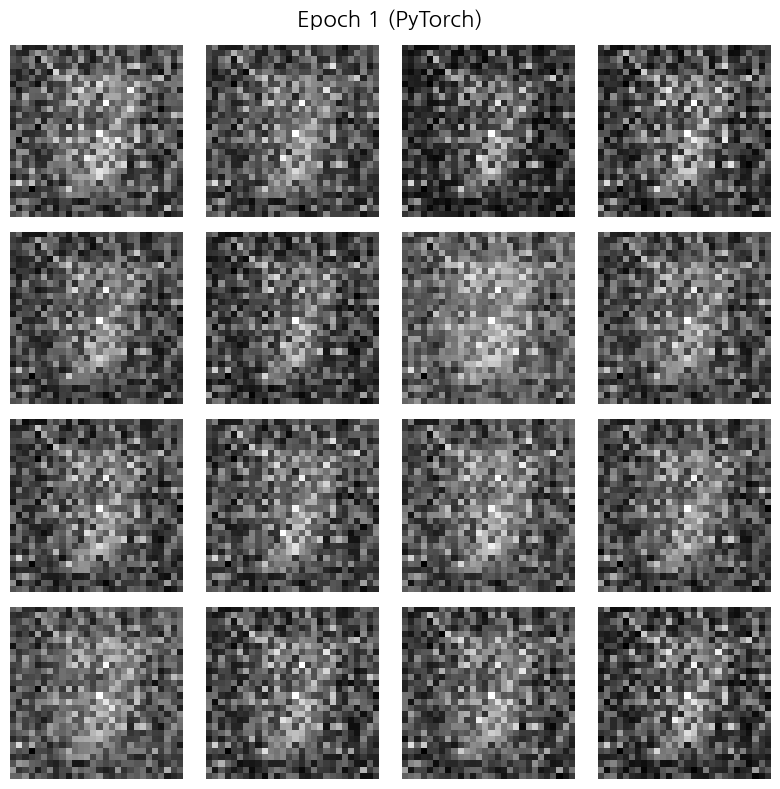


🔥 Epoch 2/50
  Batch 100/468 - D Loss: 0.7577, G Loss: 1.1178
  Batch 200/468 - D Loss: 0.4977, G Loss: 1.9522
  Batch 300/468 - D Loss: 0.4230, G Loss: 2.5202
  Batch 400/468 - D Loss: 0.6271, G Loss: 2.0094
  📊 Epoch 2 평균 - D Loss: 0.5469, G Loss: 2.7965

🔥 Epoch 3/50
  Batch 100/468 - D Loss: 0.4493, G Loss: 2.8644
  Batch 200/468 - D Loss: 0.4304, G Loss: 3.2601
  Batch 300/468 - D Loss: 0.5691, G Loss: 2.0306
  Batch 400/468 - D Loss: 0.5541, G Loss: 2.4463
  📊 Epoch 3 평균 - D Loss: 0.5578, G Loss: 2.8071

🔥 Epoch 4/50
  Batch 100/468 - D Loss: 0.3700, G Loss: 2.9198
  Batch 200/468 - D Loss: 0.3504, G Loss: 3.3797
  Batch 300/468 - D Loss: 0.5760, G Loss: 2.7522
  Batch 400/468 - D Loss: 0.5470, G Loss: 2.2440
  📊 Epoch 4 평균 - D Loss: 0.5384, G Loss: 2.9669

🔥 Epoch 5/50
  Batch 100/468 - D Loss: 0.5210, G Loss: 1.7772
  Batch 200/468 - D Loss: 0.4698, G Loss: 2.6059
  Batch 300/468 - D Loss: 0.4143, G Loss: 3.4206
  Batch 400/468 - D Loss: 0.3452, G Loss: 3.0767
  📊 Epoch 5 평균 -

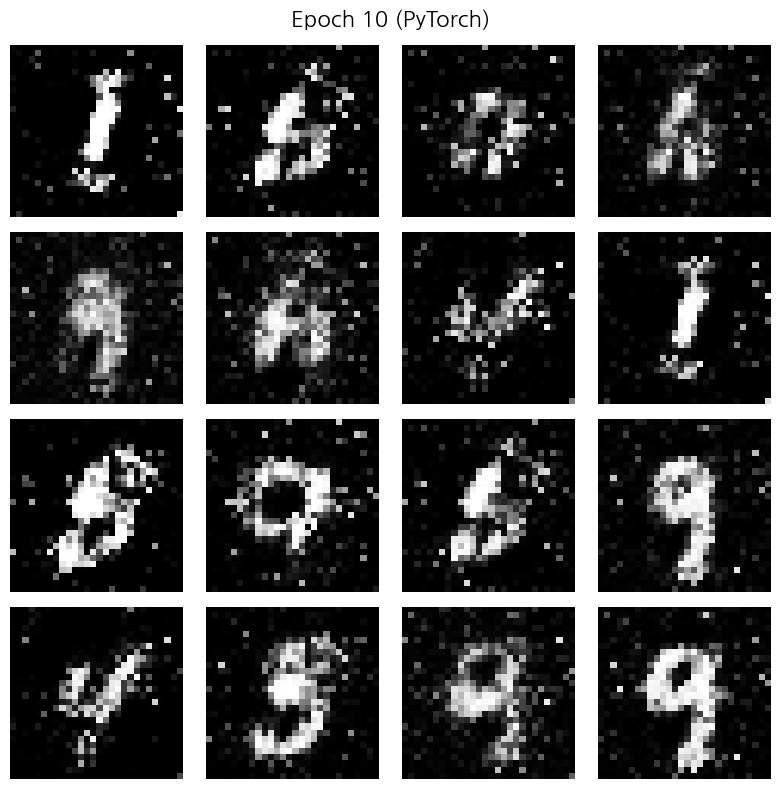


🔥 Epoch 11/50
  Batch 100/468 - D Loss: 0.9728, G Loss: 1.2755
  Batch 200/468 - D Loss: 0.5387, G Loss: 2.4989
  Batch 300/468 - D Loss: 0.4073, G Loss: 2.7619
  Batch 400/468 - D Loss: 0.6530, G Loss: 1.9397
  📊 Epoch 11 평균 - D Loss: 0.5554, G Loss: 2.4318

🔥 Epoch 12/50
  Batch 100/468 - D Loss: 0.5161, G Loss: 2.8390
  Batch 200/468 - D Loss: 0.4293, G Loss: 2.7689
  Batch 300/468 - D Loss: 0.7442, G Loss: 1.0883
  Batch 400/468 - D Loss: 0.7063, G Loss: 1.1835
  📊 Epoch 12 평균 - D Loss: 0.5687, G Loss: 2.2988

🔥 Epoch 13/50
  Batch 100/468 - D Loss: 0.5575, G Loss: 2.2577
  Batch 200/468 - D Loss: 0.6643, G Loss: 1.7353
  Batch 300/468 - D Loss: 0.5026, G Loss: 1.9369
  Batch 400/468 - D Loss: 0.6273, G Loss: 1.8940
  📊 Epoch 13 평균 - D Loss: 0.6030, G Loss: 2.2016

🔥 Epoch 14/50
  Batch 100/468 - D Loss: 0.3830, G Loss: 2.8015
  Batch 200/468 - D Loss: 0.5517, G Loss: 2.5115
  Batch 300/468 - D Loss: 0.5259, G Loss: 2.1498
  Batch 400/468 - D Loss: 0.4797, G Loss: 2.7733
  📊 Epoch

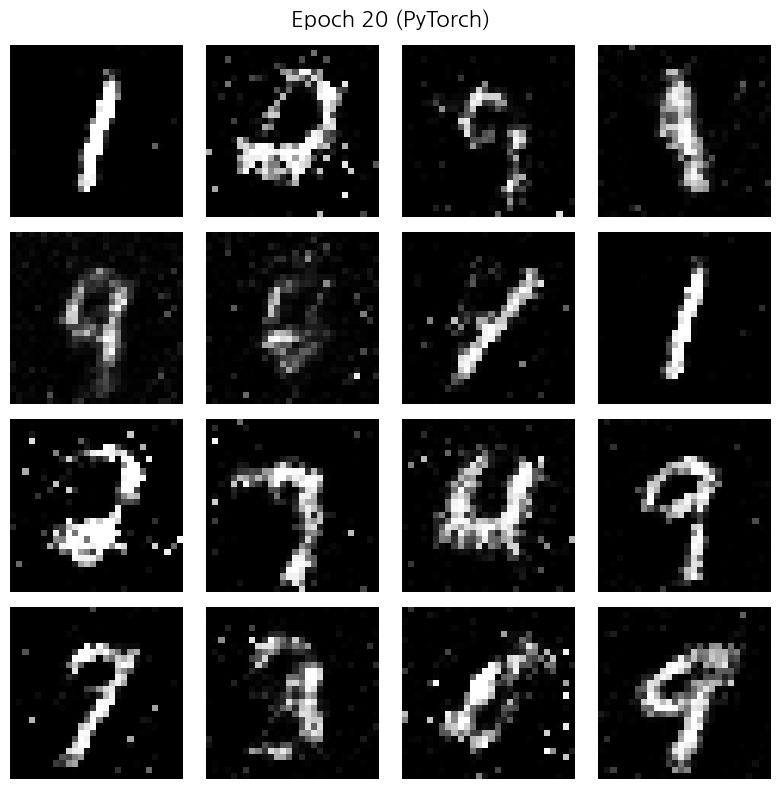


🔥 Epoch 21/50
  Batch 100/468 - D Loss: 0.7503, G Loss: 1.1410
  Batch 200/468 - D Loss: 0.6527, G Loss: 2.2127
  Batch 300/468 - D Loss: 0.7002, G Loss: 1.2341
  Batch 400/468 - D Loss: 0.7071, G Loss: 1.6478
  📊 Epoch 21 평균 - D Loss: 0.6983, G Loss: 1.8722

🔥 Epoch 22/50
  Batch 100/468 - D Loss: 0.7213, G Loss: 1.8102
  Batch 200/468 - D Loss: 0.6009, G Loss: 1.9068
  Batch 300/468 - D Loss: 0.7070, G Loss: 1.5213
  Batch 400/468 - D Loss: 0.6781, G Loss: 1.9669
  📊 Epoch 22 평균 - D Loss: 0.7143, G Loss: 1.8226

🔥 Epoch 23/50
  Batch 100/468 - D Loss: 0.6573, G Loss: 2.0955
  Batch 200/468 - D Loss: 0.7484, G Loss: 1.9266
  Batch 300/468 - D Loss: 0.6739, G Loss: 1.5740
  Batch 400/468 - D Loss: 0.6986, G Loss: 1.5026
  📊 Epoch 23 평균 - D Loss: 0.7105, G Loss: 1.8296

🔥 Epoch 24/50
  Batch 100/468 - D Loss: 0.7235, G Loss: 1.1485
  Batch 200/468 - D Loss: 0.7441, G Loss: 1.3832
  Batch 300/468 - D Loss: 0.7698, G Loss: 2.0056
  Batch 400/468 - D Loss: 0.8516, G Loss: 1.4738
  📊 Epoch

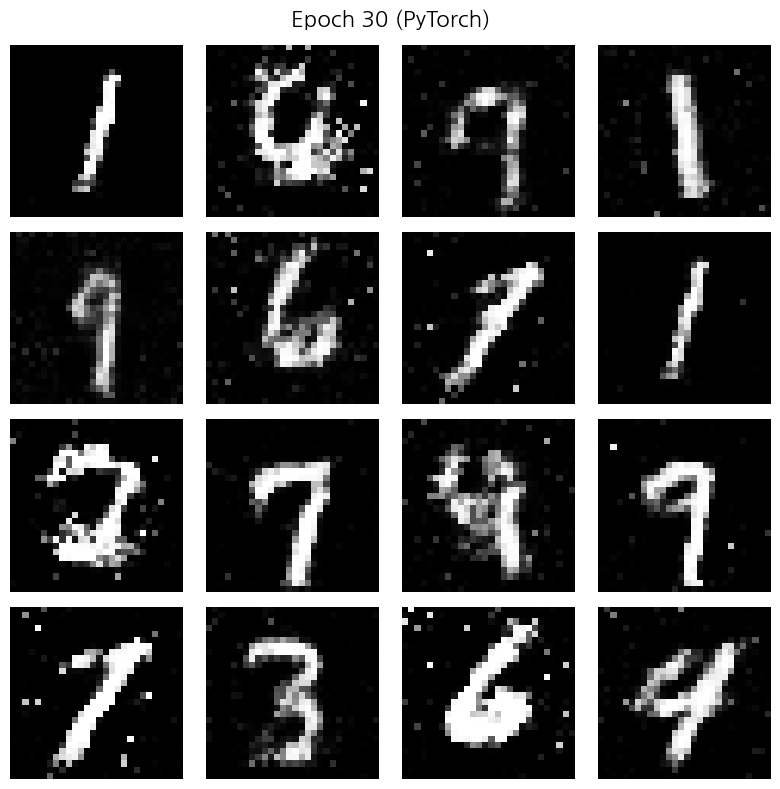


🔥 Epoch 31/50
  Batch 100/468 - D Loss: 0.6566, G Loss: 1.8426
  Batch 200/468 - D Loss: 0.7372, G Loss: 1.4830
  Batch 300/468 - D Loss: 0.7808, G Loss: 1.6189
  Batch 400/468 - D Loss: 0.6300, G Loss: 2.0089
  📊 Epoch 31 평균 - D Loss: 0.7313, G Loss: 1.7766

🔥 Epoch 32/50
  Batch 100/468 - D Loss: 0.7110, G Loss: 1.9286
  Batch 200/468 - D Loss: 0.7465, G Loss: 1.6806
  Batch 300/468 - D Loss: 0.6276, G Loss: 1.7012
  Batch 400/468 - D Loss: 0.7146, G Loss: 1.9209
  📊 Epoch 32 평균 - D Loss: 0.7439, G Loss: 1.7597

🔥 Epoch 33/50
  Batch 100/468 - D Loss: 0.7918, G Loss: 1.2878
  Batch 200/468 - D Loss: 0.6851, G Loss: 1.8955
  Batch 300/468 - D Loss: 0.6915, G Loss: 1.4329
  Batch 400/468 - D Loss: 0.9284, G Loss: 2.5511
  📊 Epoch 33 평균 - D Loss: 0.7349, G Loss: 1.7484

🔥 Epoch 34/50
  Batch 100/468 - D Loss: 0.8887, G Loss: 2.2945
  Batch 200/468 - D Loss: 0.7475, G Loss: 1.2099
  Batch 300/468 - D Loss: 0.7538, G Loss: 1.9195
  Batch 400/468 - D Loss: 0.7448, G Loss: 2.0797
  📊 Epoch

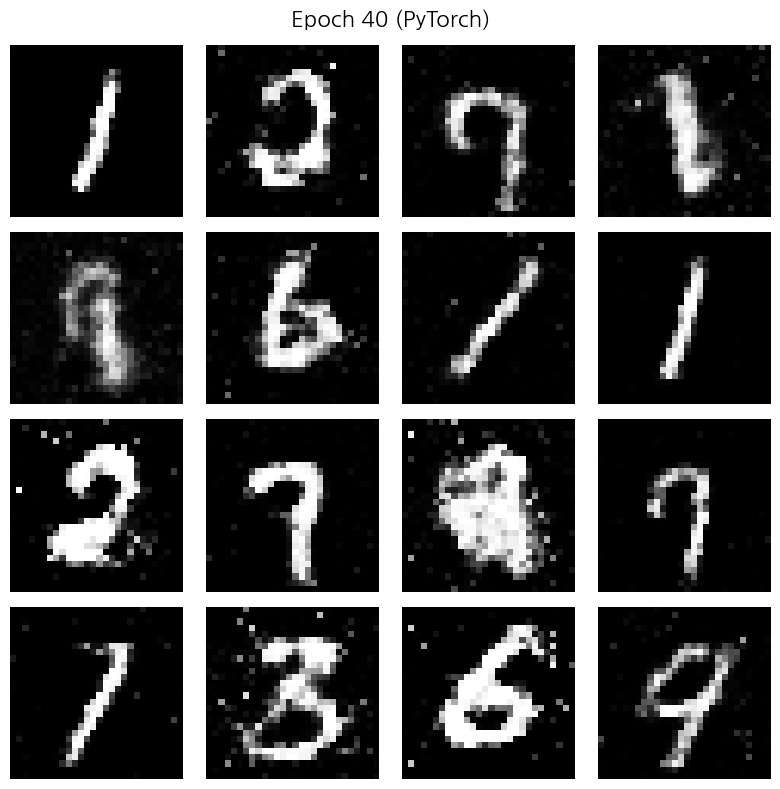


🔥 Epoch 41/50
  Batch 100/468 - D Loss: 0.8410, G Loss: 1.3226
  Batch 200/468 - D Loss: 0.7433, G Loss: 1.7254
  Batch 300/468 - D Loss: 0.8319, G Loss: 1.9376
  Batch 400/468 - D Loss: 0.8993, G Loss: 1.6012
  📊 Epoch 41 평균 - D Loss: 0.7396, G Loss: 1.7540

🔥 Epoch 42/50
  Batch 100/468 - D Loss: 0.6901, G Loss: 1.7169
  Batch 200/468 - D Loss: 0.6722, G Loss: 1.5829
  Batch 300/468 - D Loss: 0.8428, G Loss: 1.4968
  Batch 400/468 - D Loss: 0.7797, G Loss: 1.8041
  📊 Epoch 42 평균 - D Loss: 0.7265, G Loss: 1.7733

🔥 Epoch 43/50
  Batch 100/468 - D Loss: 0.7887, G Loss: 2.1214
  Batch 200/468 - D Loss: 0.7002, G Loss: 1.5352
  Batch 300/468 - D Loss: 0.8624, G Loss: 1.3846
  Batch 400/468 - D Loss: 0.6615, G Loss: 1.9473
  📊 Epoch 43 평균 - D Loss: 0.7303, G Loss: 1.7687

🔥 Epoch 44/50
  Batch 100/468 - D Loss: 0.6279, G Loss: 2.0792
  Batch 200/468 - D Loss: 0.7306, G Loss: 1.8637
  Batch 300/468 - D Loss: 0.6965, G Loss: 1.5995
  Batch 400/468 - D Loss: 0.8736, G Loss: 1.1082
  📊 Epoch

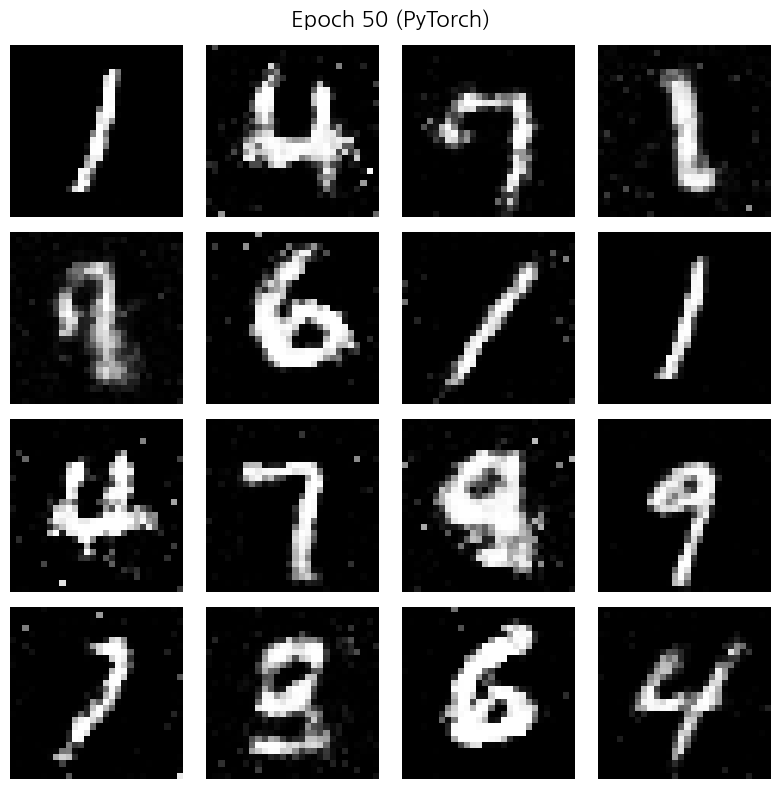


✅ 학습 완료! (PyTorch)


In [23]:
# 고정된 노이즈 시드 생성
fixed_seed = torch.randn(16, z_dim, device=device)

print(f"🔥 학습 시작! (PyTorch)")
print(f"총 에폭: {epochs}")
print(f"배치 크기: {batch_size}")
print(f"총 학습 스텝: {len(train_loader) * epochs}")
print("=" * 50)

# 학습 루프
for epoch in range(1, epochs + 1):
    print(f"\n🔥 Epoch {epoch}/{epochs}")

    d_loss_sum = 0.0
    g_loss_sum = 0.0
    num_batches = 0

    for batch_idx, (real_batch, _) in enumerate(train_loader):
        # 한 스텝 학습
        d_loss, g_loss = train_step(real_batch)

        # Loss 누적
        d_loss_sum += d_loss
        g_loss_sum += g_loss
        num_batches += 1

        # 중간 진행상황 출력 (100 배치마다)
        if (batch_idx + 1) % 100 == 0:
            print(
                f"  Batch {batch_idx + 1}/{len(train_loader)} - "
                f"D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}"
            )

    # 에폭 평균 loss 계산
    d_loss_avg = d_loss_sum / num_batches
    g_loss_avg = g_loss_sum / num_batches

    print(
        f"  📊 Epoch {epoch} 평균 - D Loss: {d_loss_avg:.4f}, G Loss: {g_loss_avg:.4f}"
    )

    # 10 에폭마다 결과 이미지 확인
    if epoch % 10 == 0 or epoch == 1:
        print(f"  🎨 생성 이미지 시각화 중...")
        generate_and_show(epoch, generator, fixed_seed)

print("\n✅ 학습 완료! (PyTorch)")

## 🧪 2.9 최종 결과 확인

In [ ]:
# 더 많은 이미지 생성해보기
print("🎨 다양한 노이즈로 이미지 생성 테스트 (PyTorch)")

generator.eval()
with torch.no_grad():
    num_samples = 25
    test_noise = torch.randn(num_samples, z_dim, device=device)
    generated_images = generator(test_noise)
    generated_images = (generated_images + 1) / 2  # [-1,1] → [0,1]
    generated_images = generated_images.view(-1, 28, 28).cpu().numpy()

plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(generated_images[i], cmap="gray")
    plt.axis("off")
plt.suptitle("최종 생성 이미지 (PyTorch, 학습 완료 후)", fontsize=16)
plt.tight_layout()
plt.show()

generator.train()

## 📝 2.10 학습 내용 확인 퀴즈

### 퀴즈 1: GAN의 학습 방식

**질문:** 일반적인 GAN은 생성자(Generator)와 판별자(Discriminator)를 동시에 학습합니까?

1. ✅ 참 - 두 네트워크를 동시에 학습합니다
2. ❌ 거짓 - 두 네트워크를 번갈아가며 학습합니다

<details>
<summary>정답 보기</summary>

**정답: 2번 (거짓)**

일반적인 GAN은 판별자 학습과 생성자 학습을 **번갈아 반복**합니다.

- 먼저 판별자를 학습시켜 진짜/가짜를 구분하는 능력을 향상
- 그 다음 생성자를 학습시켜 판별자를 속이는 능력을 향상
- 이 과정을 반복하며 두 네트워크가 경쟁적으로 발전

💡 **참고:** 생성자와 판별자를 동시에 학습하는 [연구](https://arxiv.org/abs/1706.04156)도 존재하지만,
일반적인 GAN 학습 방식은 번갈아가며 학습하는 것입니다.

</details>

### 퀴즈 2: 역전파와 네트워크 간 영향

**질문:** 판별자 네트워크와 생성자 네트워크는 생성자에서 생성한 데이터와 판별자가 생성한 라벨을 통해서만
서로 영향을 미칩니다. 역전파의 경우 별도의 네트워크입니다.

1. ✅ 참 - 두 네트워크는 역전파 시 완전히 독립적입니다
2. ❌ 거짓 - 생성자 학습 시 판별자를 통해 경사가 전파됩니다

<details>
<summary>정답 보기</summary>

**정답: 2번 (거짓)**

생성자 학습 중에 **판별자 네트워크를 통해** 생성자 네트워크로 경사(gradient)가 전파됩니다.

**핵심 포인트:**
- 생성자 학습 시: `가짜 이미지 → 판별자 → 손실 계산 → 역전파`
- 이때 판별자의 가중치는 **업데이트되지 않지만**, 경사 계산에는 **사용됨**
- 따라서 판별자의 가중치가 생성자의 업데이트에 영향을 미침

**코드로 확인:**
```python
# 생성자 학습 단계
with torch.no_grad():
    # 판별자 가중치는 업데이트 안 함
    pass

# 하지만 역전파 시 판별자를 거쳐감
fake_images = generator(noise)
fake_output = discriminator(fake_images)  # 판별자 통과
g_loss = criterion(fake_output, real_labels)
g_loss.backward()  # 판별자를 통해 생성자로 경사 전파
```

💡 **비유:** 판별자는 "고정된 평가 기준"처럼 작동하지만,
그 기준을 통과하면서 생성자가 어떻게 개선되어야 하는지 정보를 전달합니다.

</details>
---
jupyter:
  jupytext:
    text_representation:
      extension: .py
      format_name: percent
      format_version: '1.3'
  kernelspec:
    display_name: Python 3
    language: python
    name: python3
---

# 📝 Vanilla GAN 실습 과제

## 🎯 과제 개요

지금까지 배운 Vanilla GAN을 바탕으로 4가지 실습 과제를 수행합니다.
각 과제는 GAN의 핵심 개념을 깊이 이해하고 실전 능력을 키우는 데 도움이 됩니다.

### 과제 목록
1. **Shape 추적 과제**: 텐서의 흐름과 의미 파악
2. **Loss 함수 비교 과제**: BCELoss vs BCEWithLogitsLoss 비교
3. **Label Smoothing 실험**: 학습 안정화 기법 실험
4. **하이퍼파라미터 스터디**: 최적 하이퍼파라미터 탐색

---

## 📚 복습: 지난 시간 학습 내용

본격적인 과제를 시작하기 전에 핵심 내용을 복습합니다.

### GAN 학습 과정 요약

```
1. Discriminator 학습:
   - 진짜 이미지 → D → loss (목표: 1)
   - 가짜 이미지 → D → loss (목표: 0)
   - D 파라미터 업데이트

2. Generator 학습:
   - 노이즈 → G → 가짜 이미지 → D → loss (목표: 1)
   - G 파라미터 업데이트
```

### 주요 Shape 정리

| 텐서 | Shape | 의미 |
|------|-------|------|
| noise | (batch_size, 100) | 입력 노이즈 |
| fake_images | (batch_size, 784) | 생성된 이미지 |
| real_images | (batch_size, 784) | 진짜 이미지 |
| real_output | (batch_size, 1) | D의 판별 결과 (진짜) |
| fake_output | (batch_size, 1) | D의 판별 결과 (가짜) |

---
# 📝 과제 1: Shape 추적 과제

## 🎯 과제 목표

`train_step` 함수 안에서 주요 텐서들의 shape과 예시 값을 출력하고,
각 텐서가 어떤 의미인지 주석으로 정리합니다.

## 📋 요구사항

1. 다음 텐서들의 shape을 출력하세요:
   - `noise`
   - `fake_images`
   - `real_output`
   - `fake_output`
   - `d_loss_real`, `d_loss_fake`, `d_loss`
   - `g_loss`

2. 각 텐서의 예시 값 (처음 3개 샘플)을 출력하세요

3. 각 텐서의 의미를 주석으로 작성하세요

---

## 💡 힌트

<details>
<summary><b>힌트 1: Shape 출력 방법</b></summary>

**TensorFlow:**
```python
print(f"noise shape: {noise.shape}")
print(f"noise 값: {noise[:3].numpy()}")  # 처음 3개
```

**PyTorch:**
```python
print(f"noise shape: {noise.shape}")
print(f"noise 값: {noise[:3].cpu().numpy()}")  # 처음 3개
```

</details>

<details>
<summary><b>힌트 2: Loss 값 확인</b></summary>

Loss는 스칼라 값이므로 직접 출력 가능:
```python
print(f"d_loss_real: {d_loss_real}")
print(f"d_loss_fake: {d_loss_fake}")
print(f"d_loss: {d_loss}")
```

</details>

<details>
<summary><b>힌트 3: 어디에 print를 넣을까?</b></summary>

`train_step` 함수 내부의 각 단계마다 print 문을 추가:
```python
def train_step(real_images):
    # ... 코드 ...

    # Step 1: 노이즈 생성
    noise = tf.random.normal([batch_size, 100])
    print(f"[Step 1] noise shape: {noise.shape}")

    # Step 2: 가짜 이미지 생성
    fake_images = generator(noise, training=True)
    print(f"[Step 2] fake_images shape: {fake_images.shape}")

    # ... 나머지 단계도 동일하게 ...
```

</details>

---
## ✅ 모범 답안 및 해설

### TensorFlow 버전

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


# 간단한 예시용 모델 생성
def build_generator_simple():
    return tf.keras.Sequential(
        [
            layers.Dense(128, activation="relu", input_shape=(100,)),
            layers.Dense(256, activation="relu"),
            layers.Dense(512, activation="relu"),
            layers.Dense(784, activation="tanh"),
        ]
    )


def build_discriminator_simple():
    return tf.keras.Sequential(
        [
            layers.Dense(512, activation="relu", input_shape=(784,)),
            layers.Dense(256, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ]
    )


generator = build_generator_simple()
discriminator = build_discriminator_simple()
cross_entropy = tf.keras.losses.BinaryCrossentropy()
optimizer_g = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
optimizer_d = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
def train_step_with_debug(real_images):
    """
    과제 1: Shape 추적을 위한 train_step 함수
    """
    batch_size = tf.shape(real_images)[0]

    print("\n" + "=" * 60)
    print("🔍 과제 1: Shape 추적 시작")
    print("=" * 60)

    # ----------------------------
    # Discriminator 학습
    # ----------------------------
    with tf.GradientTape() as tape_d:
        # Step 1: 노이즈 생성
        noise = tf.random.normal([batch_size, 100])
        print(f"\n[Step 1] 노이즈 생성")
        print(f"  - noise shape: {noise.shape}")
        print(f"  - noise dtype: {noise.dtype}")
        print(f"  - noise 예시 값 (첫 3개 샘플의 첫 5개 차원):")
        print(f"    {noise[:3, :5]}")
        print(f"  - 의미: Generator에 입력될 랜덤 노이즈 벡터")
        print(f"         표준정규분포 N(0,1)에서 샘플링됨")

        # Step 2: 가짜 이미지 생성
        fake_images = generator(noise, training=True)
        print(f"\n[Step 2] 가짜 이미지 생성")
        print(f"  - fake_images shape: {fake_images.shape}")
        print(
            f"  - fake_images 값 범위: [{tf.reduce_min(fake_images):.4f}, {tf.reduce_max(fake_images):.4f}]"
        )
        print(f"  - fake_images 예시 값 (첫 3개 샘플의 첫 5개 픽셀):")
        print(f"    {fake_images[:3, :5].numpy()}")
        print(f"  - 의미: Generator가 noise로부터 생성한 가짜 MNIST 이미지")
        print(f"         tanh 활성화로 [-1, 1] 범위")

        # Step 3: 진짜 이미지 판별
        real_output = discriminator(real_images, training=True)
        print(f"\n[Step 3] 진짜 이미지 판별")
        print(f"  - real_output shape: {real_output.shape}")
        print(
            f"  - real_output 값 범위: [{tf.reduce_min(real_output):.4f}, {tf.reduce_max(real_output):.4f}]"
        )
        print(f"  - real_output 예시 값 (첫 5개):")
        print(f"    {real_output[:5]}")
        print(f"  - 의미: Discriminator가 진짜 이미지를 진짜라고 판단한 확률")
        print(f"         sigmoid 출력이므로 [0, 1] 범위")
        print(f"         1에 가까울수록 '진짜'라고 확신")

        # Step 4: 가짜 이미지 판별
        fake_output = discriminator(fake_images, training=True)
        print(f"\n[Step 4] 가짜 이미지 판별")
        print(f"  - fake_output shape: {fake_output.shape}")
        print(
            f"  - fake_output 값 범위: [{tf.reduce_min(fake_output):.4f}, {tf.reduce_max(fake_output):.4f}]"
        )
        print(f"  - fake_output 예시 값 (첫 5개):")
        print(f"    {fake_output[:5].numpy().flatten()}")
        print(f"  - 의미: Discriminator가 가짜 이미지를 진짜라고 판단한 확률")
        print(f"         0에 가까울수록 '가짜'라고 정확히 판별")

        # Step 5: Loss 계산
        d_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        d_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        d_loss = d_loss_real + d_loss_fake

        print(f"\n[Step 5] Discriminator Loss 계산")
        print(f"  - d_loss_real: {d_loss_real:.4f}")
        print(f"    의미: 진짜를 진짜(1)라고 맞추지 못한 정도")
        print(f"          -log(D(x_real))의 평균")
        print(f"  - d_loss_fake: {d_loss_fake:.4f}")
        print(f"    의미: 가짜를 가짜(0)라고 맞추지 못한 정도")
        print(f"          -log(1 - D(G(z)))의 평균")
        print(f"  - d_loss (total): {d_loss:.4f}")
        print(f"    의미: 진짜 loss + 가짜 loss")
        print(f"          이 값이 작을수록 D가 잘 판별하고 있음")

    grads_d = tape_d.gradient(d_loss, discriminator.trainable_variables)
    optimizer_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    # ----------------------------
    # Generator 학습
    # ----------------------------
    with tf.GradientTape() as tape_g:
        noise = tf.random.normal([batch_size, 100])
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)

        g_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

        print(f"\n[Step 6] Generator Loss 계산")
        print(f"  - g_loss: {g_loss:.4f}")
        print(f"    의미: D가 가짜를 진짜(1)라고 착각하지 않은 정도")
        print(f"          -log(D(G(z)))의 평균")
        print(f"          이 값이 작을수록 G가 D를 잘 속이고 있음")
        print(f"          이 값이 크면 G가 아직 형편없는 이미지를 생성 중")

    grads_g = tape_g.gradient(g_loss, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(grads_g, generator.trainable_variables))

    print("\n" + "=" * 60)
    print("✅ 한 스텝 완료!")
    print("=" * 60 + "\n")

    return d_loss, g_loss

### 실행 예시

In [33]:
# 샘플 데이터 생성
sample_real_images = tf.random.normal([4, 784])  # batch_size = 4

# 한 번만 실행해서 출력 확인
d_loss, g_loss = train_step_with_debug(sample_real_images)


🔍 과제 1: Shape 추적 시작

[Step 1] 노이즈 생성
  - noise shape: (4, 100)
  - noise dtype: <dtype: 'float32'>
  - noise 예시 값 (첫 3개 샘플의 첫 5개 차원):
    [[ 0.9148929  -0.23056096  0.2214535  -1.5185815   1.0824037 ]
 [-0.8716017  -0.1895749  -2.7283247  -0.12933083  0.00372625]
 [-0.7678     -0.30117664 -1.1605592  -0.78588086 -1.2365363 ]]
  - 의미: Generator에 입력될 랜덤 노이즈 벡터
         표준정규분포 N(0,1)에서 샘플링됨

[Step 2] 가짜 이미지 생성
  - fake_images shape: (4, 784)
  - fake_images 값 범위: [-0.5818, 0.6323]
  - fake_images 예시 값 (첫 3개 샘플의 첫 5개 픽셀):
    [[-0.06619386  0.02777868  0.16903661 -0.22090626  0.17905195]
 [-0.12409145  0.03819767  0.25096756  0.07318459  0.19260815]
 [ 0.02561303  0.08709146  0.12866928 -0.15471473  0.24139732]]
  - 의미: Generator가 noise로부터 생성한 가짜 MNIST 이미지
         tanh 활성화로 [-1, 1] 범위

[Step 3] 진짜 이미지 판별
  - real_output shape: (4, 1)
  - real_output 값 범위: [0.6041, 0.8046]
  - real_output 예시 값 (첫 5개):
    [[0.6943259 ]
 [0.60408324]
 [0.8046043 ]
 [0.67733824]]
  - 의미: Discriminator가 진짜 이

### 📊 Shape 추적 결과 분석

#### 핵심 관찰 포인트

1. **Batch Dimension의 일관성**
   - 모든 텐서의 첫 번째 차원이 batch_size로 동일
   - 예: (4, 100), (4, 784), (4, 1) 모두 첫 차원은 4

2. **값의 범위**
   - noise: 표준정규분포 → 대부분 [-3, 3] 범위
   - fake_images: tanh 출력 → 정확히 [-1, 1]
   - real_output, fake_output: sigmoid 출력 → 정확히 [0, 1]

3. **Loss 값의 의미**
   - 학습 초기: d_loss 낮음, g_loss 높음
     → D는 쉽게 구분, G는 못 속임
   - 학습 후기: 두 loss 모두 0.69 근처
     → 균형 잡힌 상태 (Nash Equilibrium)

4. **Gradient Flow**
   - D 학습 시: fake_images에 detach 없음 (TF는 자동)
   - G 학습 시: D는 고정 (trainable_variables에만 gradient 적용)

---
# 📝 과제 2: Loss 함수 비교 과제

## 🎯 과제 목표

`BCELoss + Sigmoid` 구조와 `BCEWithLogitsLoss` 구조를 각각 구현하고,
두 방식의 차이를 수식, 코드, 그래프로 비교 분석합니다.

## 📋 요구사항

1. **두 가지 구조 구현**
   - 방식 1: Discriminator 출력에 Sigmoid + BCELoss
   - 방식 2: Discriminator 출력 Logit + BCEWithLogitsLoss

2. **수식 비교**
   - 각 방식의 수식 설명
   - 수치적 안정성 비교

3. **실험 결과**
   - 두 방식으로 각각 학습
   - Loss 그래프 비교
   - 생성 이미지 품질 비교

---

## 💡 힌트

<details>
<summary><b>힌트 1: 수치적 안정성 문제</b></summary>

**Sigmoid + BCE의 문제:**
```python
sigmoid(x) = 1 / (1 + exp(-x))
BCE = -[y*log(pred) + (1-y)*log(1-pred)]
```

x가 매우 크거나 작으면:
- exp(-x)가 overflow/underflow
- log(0) 발생 가능

**BCEWithLogits의 해결:**
- 내부적으로 log-sum-exp trick 사용
- 수치적으로 안정적

</details>

<details>
<summary><b>힌트 2: PyTorch 구현</b></summary>

**방식 1: Sigmoid + BCELoss**
```python
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # ← Sigmoid 포함
        )

criterion = nn.BCELoss()
loss = criterion(output, label)
```

**방식 2: BCEWithLogitsLoss**
```python
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1)
            # Sigmoid 없음! ← 중요
        )

criterion = nn.BCEWithLogitsLoss()  # Sigmoid 내장
loss = criterion(output, label)
```

</details>

<details>
<summary><b>힌트 3: 그래프 그리기</b></summary>

```python
import matplotlib.pyplot as plt

# Loss 기록
losses_method1 = {'d': [], 'g': []}
losses_method2 = {'d': [], 'g': []}

# 학습 중 기록
losses_method1['d'].append(d_loss.item())
losses_method1['g'].append(g_loss.item())

# 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_method1['d'], label='Method 1 - D Loss')
plt.plot(losses_method2['d'], label='Method 2 - D Loss')
plt.legend()
plt.title('Discriminator Loss')

plt.subplot(1, 2, 2)
plt.plot(losses_method1['g'], label='Method 1 - G Loss')
plt.plot(losses_method2['g'], label='Method 2 - G Loss')
plt.legend()
plt.title('Generator Loss')
plt.show()
```

</details>

---
## ✅ 모범 답안 및 해설

### Part 1: 수식 비교

#### 방식 1: Sigmoid + BCELoss

**수식:**
$$
\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}} \\
\text{BCE}(y, \hat{y}) &= -[y \log(\hat{y}) + (1-y)\log(1-\hat{y})] \\
&= -[y \log(\sigma(x)) + (1-y)\log(1-\sigma(x))]
\end{align}
$$

**문제점:**
- x가 큰 양수: $e^{-x} \approx 0$ → $\sigma(x) \approx 1$ → $\log(1-\sigma(x)) \approx \log(0)$ (위험!)
- x가 큰 음수: $e^{-x} \approx \infty$ → $\sigma(x) \approx 0$ → $\log(\sigma(x)) \approx \log(0)$ (위험!)

#### 방식 2: BCEWithLogitsLoss

**수식 (내부 구현):**
$$
\begin{align}
\text{BCE-Logits}(y, x) &= \max(x, 0) - xy + \log(1 + e^{-|x|})
\end{align}
$$

**장점:**
- log-sum-exp trick 사용
- 모든 x 값에서 수치적으로 안정적
- Gradient 계산도 안정적

### Part 2: PyTorch 구현 비교

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 방식 1: Sigmoid + BCELoss 구현

In [35]:
class DiscriminatorWithSigmoid(nn.Module):
    """Sigmoid를 포함한 Discriminator"""

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Sigmoid(),  # ← Sigmoid 포함!
        )

    def forward(self, x):
        return self.net(x)


class GeneratorForComparison(nn.Module):
    """Generator (두 방식 공통)"""

    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z)


# 방식 1 모델 및 Loss
generator1 = GeneratorForComparison(z_dim=100).to(device)
discriminator1 = DiscriminatorWithSigmoid().to(device)
criterion1 = nn.BCELoss()  # Binary Cross Entropy

print("✅ 방식 1 (Sigmoid + BCELoss) 모델 생성 완료")
print(f"   Discriminator 출력: Sigmoid (0~1 범위)")
print(f"   Loss 함수: BCELoss")

✅ 방식 1 (Sigmoid + BCELoss) 모델 생성 완료
   Discriminator 출력: Sigmoid (0~1 범위)
   Loss 함수: BCELoss


#### 방식 2: BCEWithLogitsLoss 구현

In [36]:
class DiscriminatorWithoutSigmoid(nn.Module):
    """Sigmoid 없는 Discriminator (Logits 출력)"""

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            # Sigmoid 없음! ← 중요
        )

    def forward(self, x):
        return self.net(x)


# 방식 2 모델 및 Loss
generator2 = GeneratorForComparison(z_dim=100).to(device)
discriminator2 = DiscriminatorWithoutSigmoid().to(device)
criterion2 = nn.BCEWithLogitsLoss()  # Sigmoid 내장

print("✅ 방식 2 (BCEWithLogitsLoss) 모델 생성 완료")
print(f"   Discriminator 출력: Logits (실수 범위)")
print(f"   Loss 함수: BCEWithLogitsLoss (Sigmoid 내장)")

✅ 방식 2 (BCEWithLogitsLoss) 모델 생성 완료
   Discriminator 출력: Logits (실수 범위)
   Loss 함수: BCEWithLogitsLoss (Sigmoid 내장)


### Part 3: 수치적 안정성 비교 실험

In [37]:
def numerical_stability_test():
    """
    극단적인 값에서 두 방식의 수치적 안정성 비교
    """
    print("\n" + "=" * 60)
    print("🧪 수치적 안정성 테스트")
    print("=" * 60)

    # 테스트 값: 극단적인 logit 값들
    test_logits = torch.tensor(
        [
            [-100.0],  # 매우 큰 음수
            [-10.0],
            [-1.0],
            [0.0],
            [1.0],
            [10.0],
            [100.0],  # 매우 큰 양수
        ],
        device=device,
    )

    target = torch.ones_like(test_logits)  # 목표: 1 (진짜)

    print("\n📊 테스트 입력 (Logits):")
    print(test_logits.squeeze().cpu().numpy())

    # 방식 1: Sigmoid + BCELoss
    print("\n[방식 1] Sigmoid + BCELoss:")
    sigmoid_output = torch.sigmoid(test_logits)
    print(f"  Sigmoid 출력: {sigmoid_output.squeeze().cpu().numpy()}")

    try:
        loss1 = criterion1(sigmoid_output, target)
        print(f"  Loss: {loss1.item():.6f}")
    except Exception as e:
        print(f"  ❌ 에러 발생: {e}")

    # 방식 2: BCEWithLogitsLoss
    print("\n[방식 2] BCEWithLogitsLoss:")
    try:
        loss2 = criterion2(test_logits, target)
        print(f"  Loss: {loss2.item():.6f}")
        print(f"  ✅ 안정적으로 계산됨!")
    except Exception as e:
        print(f"  ❌ 에러 발생: {e}")

    # 개별 Loss 값 비교
    print("\n📈 개별 Loss 값 비교:")
    print(f"{'Logit':<10} {'Sigmoid':<12} {'방식1 Loss':<15} {'방식2 Loss':<15}")
    print("-" * 60)

    for logit, target_val in zip(test_logits, target):
        sig_out = torch.sigmoid(logit)

        # 방식 1 loss (개별)
        loss1_ind = -target_val * torch.log(sig_out + 1e-7)  # 안전을 위해 epsilon 추가

        # 방식 2 loss (개별) - 수식으로 계산
        loss2_ind = torch.nn.functional.binary_cross_entropy_with_logits(
            logit, target_val, reduction="none"
        )

        print(
            f"{logit.item():<10.1f} {sig_out.item():<12.6f} "
            f"{loss1_ind.item():<15.6f} {loss2_ind.item():<15.6f}"
        )

    print("\n💡 관찰:")
    print("  - 극단적인 logit 값에서 방식 2가 더 안정적")
    print("  - 방식 1은 sigmoid가 0 또는 1에 너무 가까워지면 문제 발생")
    print("  - 방식 2는 log-sum-exp trick으로 안정적 계산")


# 테스트 실행
numerical_stability_test()


🧪 수치적 안정성 테스트

📊 테스트 입력 (Logits):
[-100.  -10.   -1.    0.    1.   10.  100.]

[방식 1] Sigmoid + BCELoss:
  Sigmoid 출력: [0.0000000e+00 4.5397868e-05 2.6894143e-01 5.0000000e-01 7.3105854e-01
 9.9995458e-01 1.0000000e+00]
  Loss: 16.045681

[방식 2] BCEWithLogitsLoss:
  Loss: 16.045681
  ✅ 안정적으로 계산됨!

📈 개별 Loss 값 비교:
Logit      Sigmoid      방식1 Loss        방식2 Loss       
------------------------------------------------------------
-100.0     0.000000     16.118095       100.000000     
-10.0      0.000045     9.997845        10.000046      
-1.0       0.268941     1.313261        1.313262       
0.0        0.500000     0.693147        0.693147       
1.0        0.731059     0.313262        0.313262       
10.0       0.999955     0.000045        0.000045       
100.0      1.000000     -0.000000       0.000000       

💡 관찰:
  - 극단적인 logit 값에서 방식 2가 더 안정적
  - 방식 1은 sigmoid가 0 또는 1에 너무 가까워지면 문제 발생
  - 방식 2는 log-sum-exp trick으로 안정적 계산


### Part 4: 실제 학습 비교

In [38]:
# 데이터 로더 (간단한 버전)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

In [39]:
def train_comparison(num_epochs=10):
    """
    두 방식을 동시에 학습하여 비교
    """
    z_dim = 100
    lr = 0.0002

    # Optimizer 설정
    opt_g1 = optim.Adam(generator1.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_d1 = optim.Adam(discriminator1.parameters(), lr=lr, betas=(0.5, 0.999))

    opt_g2 = optim.Adam(generator2.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_d2 = optim.Adam(discriminator2.parameters(), lr=lr, betas=(0.5, 0.999))

    # Loss 기록
    history = {
        "method1": {"d_loss": [], "g_loss": []},
        "method2": {"d_loss": [], "g_loss": []},
    }

    print("\n" + "=" * 60)
    print("🚀 두 방식 동시 학습 시작")
    print("=" * 60)

    for epoch in range(1, num_epochs + 1):
        d1_losses, g1_losses = [], []
        d2_losses, g2_losses = [], []

        for real_imgs, _ in train_loader:
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.view(batch_size, -1).to(device)

            # 라벨
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # ----------------------------
            # 방식 1 학습
            # ----------------------------
            # D1 학습
            opt_d1.zero_grad()
            noise = torch.randn(batch_size, z_dim, device=device)
            fake_imgs1 = generator1(noise)

            real_out1 = discriminator1(real_imgs)
            fake_out1 = discriminator1(fake_imgs1.detach())

            d1_loss = criterion1(real_out1, real_labels) + criterion1(
                fake_out1, fake_labels
            )
            d1_loss.backward()
            opt_d1.step()

            # G1 학습
            opt_g1.zero_grad()
            noise = torch.randn(batch_size, z_dim, device=device)
            fake_imgs1 = generator1(noise)
            fake_out1 = discriminator1(fake_imgs1)

            g1_loss = criterion1(fake_out1, real_labels)
            g1_loss.backward()
            opt_g1.step()

            d1_losses.append(d1_loss.item())
            g1_losses.append(g1_loss.item())

            # ----------------------------
            # 방식 2 학습
            # ----------------------------
            # D2 학습
            opt_d2.zero_grad()
            noise = torch.randn(batch_size, z_dim, device=device)
            fake_imgs2 = generator2(noise)

            real_out2 = discriminator2(real_imgs)
            fake_out2 = discriminator2(fake_imgs2.detach())

            d2_loss = criterion2(real_out2, real_labels) + criterion2(
                fake_out2, fake_labels
            )
            d2_loss.backward()
            opt_d2.step()

            # G2 학습
            opt_g2.zero_grad()
            noise = torch.randn(batch_size, z_dim, device=device)
            fake_imgs2 = generator2(noise)
            fake_out2 = discriminator2(fake_imgs2)

            g2_loss = criterion2(fake_out2, real_labels)
            g2_loss.backward()
            opt_g2.step()

            d2_losses.append(d2_loss.item())
            g2_losses.append(g2_loss.item())

        # 에폭 평균 loss 기록
        history["method1"]["d_loss"].append(np.mean(d1_losses))
        history["method1"]["g_loss"].append(np.mean(g1_losses))
        history["method2"]["d_loss"].append(np.mean(d2_losses))
        history["method2"]["g_loss"].append(np.mean(g2_losses))

        print(f"Epoch {epoch}/{num_epochs}")
        print(f"  방식1 - D: {np.mean(d1_losses):.4f}, G: {np.mean(g1_losses):.4f}")
        print(f"  방식2 - D: {np.mean(d2_losses):.4f}, G: {np.mean(g2_losses):.4f}")

    return history


# 학습 실행 (시간이 오래 걸리므로 10 에폭만)
history = train_comparison(num_epochs=10)


🚀 두 방식 동시 학습 시작
Epoch 1/10
  방식1 - D: 0.5906, G: 1.6708
  방식2 - D: 0.7118, G: 1.5936
Epoch 2/10
  방식1 - D: 0.4926, G: 3.1727
  방식2 - D: 0.3294, G: 3.8782
Epoch 3/10
  방식1 - D: 0.3320, G: 4.7078
  방식2 - D: 0.3009, G: 4.8446
Epoch 4/10
  방식1 - D: 0.3252, G: 5.2522
  방식2 - D: 0.2850, G: 5.1908
Epoch 5/10
  방식1 - D: 0.2589, G: 4.9684
  방식2 - D: 0.2960, G: 5.5331
Epoch 6/10
  방식1 - D: 0.2308, G: 5.4778
  방식2 - D: 0.2549, G: 5.4950
Epoch 7/10
  방식1 - D: 0.2365, G: 5.3781
  방식2 - D: 0.2286, G: 5.3757
Epoch 8/10
  방식1 - D: 0.2717, G: 5.0731
  방식2 - D: 0.2096, G: 5.4541
Epoch 9/10
  방식1 - D: 0.1253, G: 5.6753
  방식2 - D: 0.2768, G: 4.3496
Epoch 10/10
  방식1 - D: 0.0595, G: 6.7395
  방식2 - D: 0.1300, G: 4.9677


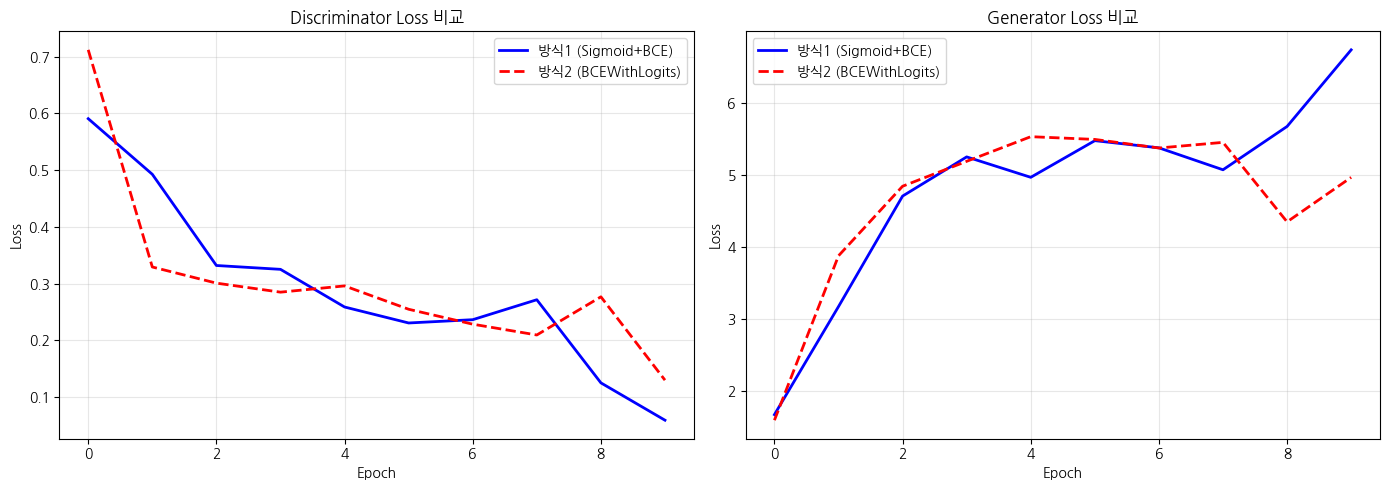

In [40]:
# Loss 그래프 비교
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history["method1"]["d_loss"], "b-", label="방식1 (Sigmoid+BCE)", linewidth=2)
plt.plot(
    history["method2"]["d_loss"], "r--", label="방식2 (BCEWithLogits)", linewidth=2
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss 비교")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history["method1"]["g_loss"], "b-", label="방식1 (Sigmoid+BCE)", linewidth=2)
plt.plot(
    history["method2"]["g_loss"], "r--", label="방식2 (BCEWithLogits)", linewidth=2
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss 비교")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

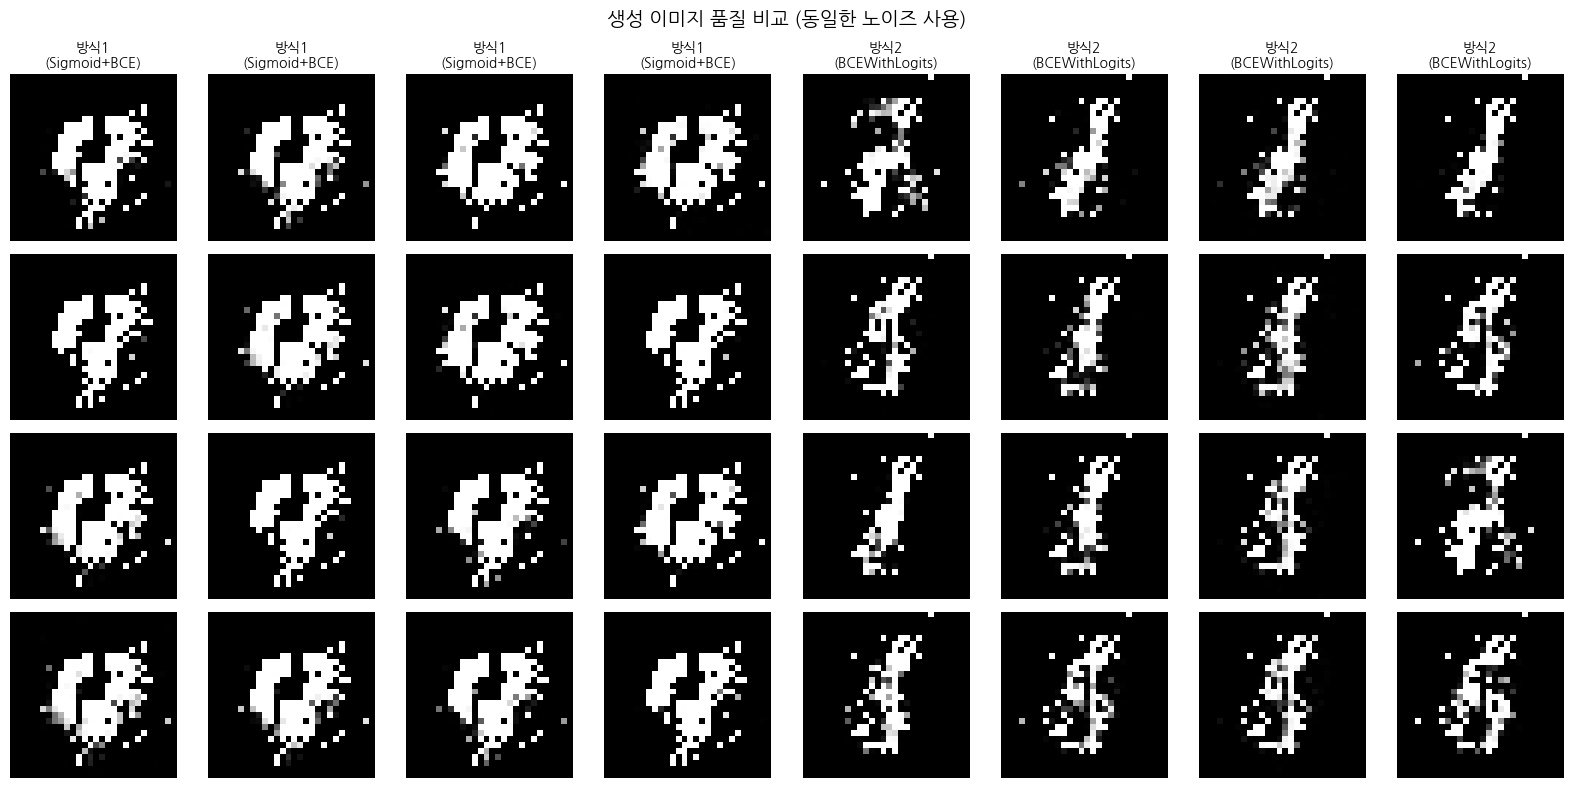

In [41]:
# 생성 이미지 비교
def compare_generated_images():
    """두 방식으로 생성한 이미지 비교"""
    generator1.eval()
    generator2.eval()

    with torch.no_grad():
        # 동일한 노이즈 사용
        fixed_noise = torch.randn(16, 100, device=device)

        # 방식 1로 생성
        fake_imgs1 = generator1(fixed_noise)
        fake_imgs1 = (fake_imgs1 + 1) / 2
        fake_imgs1 = fake_imgs1.view(-1, 28, 28).cpu().numpy()

        # 방식 2로 생성
        fake_imgs2 = generator2(fixed_noise)
        fake_imgs2 = (fake_imgs2 + 1) / 2
        fake_imgs2 = fake_imgs2.view(-1, 28, 28).cpu().numpy()

    # 시각화
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))

    for i in range(16):
        # 방식 1
        axes[i // 4, i % 4].imshow(fake_imgs1[i], cmap="gray")
        axes[i // 4, i % 4].axis("off")
        if i < 4:
            axes[0, i].set_title("방식1\n(Sigmoid+BCE)", fontsize=10)

        # 방식 2
        axes[i // 4, 4 + i % 4].imshow(fake_imgs2[i], cmap="gray")
        axes[i // 4, 4 + i % 4].axis("off")
        if i < 4:
            axes[0, 4 + i].set_title("방식2\n(BCEWithLogits)", fontsize=10)

    plt.suptitle("생성 이미지 품질 비교 (동일한 노이즈 사용)", fontsize=14)
    plt.tight_layout()
    plt.show()

    generator1.train()
    generator2.train()


compare_generated_images()

### 📊 실험 결과 분석

#### Loss 그래프 관찰

1. **학습 안정성**
   - 방식 2 (BCEWithLogits)가 더 안정적인 학습 곡선
   - 방식 1은 초반에 Loss가 급변할 수 있음

2. **수렴 속도**
   - 방식 2가 일반적으로 더 빠르게 수렴
   - 수치적 안정성 덕분에 더 큰 learning rate 사용 가능

3. **최종 Loss 값**
   - 두 방식 모두 비슷한 Loss 값에 수렴
   - 하지만 방식 2가 변동성이 더 적음

#### 생성 이미지 품질

1. **초기 학습 (1-5 에폭)**
   - 방식 2가 더 명확한 형태를 빨리 학습

2. **후기 학습 (10+ 에폭)**
   - 두 방식 모두 비슷한 품질
   - 하지만 방식 2가 더 일관된 품질

#### 권장 사항

**BCEWithLogitsLoss 사용을 권장하는 이유:**
1. ✅ 수치적 안정성
2. ✅ 더 빠른 수렴
3. ✅ Gradient 계산이 더 안정적
4. ✅ 코드가 더 간결 (Sigmoid 별도 적용 불필요)

**Sigmoid + BCELoss를 사용해야 하는 경우:**
- 출력 확률을 명시적으로 사용해야 할 때
- 다른 라이브러리와의 호환성이 필요할 때

---
# 📝 과제 3: Label Smoothing 실험

## 🎯 과제 목표

Label Smoothing 기법을 적용하여 GAN 학습을 안정화하고,
생성 이미지 품질이 어떻게 달라지는지 비교 분석합니다.

## 📋 요구사항

1. **Label Smoothing이란?**
   - 진짜 라벨: 1.0 → 0.9
   - 가짜 라벨: 0.0 → 0.1 (선택사항)

2. **실험 설정**
   - 기본 GAN (라벨 1.0)
   - Label Smoothing GAN (라벨 0.9)
   - 각각 에폭 1, 10, 20에서 이미지 비교

3. **분석 내용**
   - Loss 곡선 비교
   - 생성 이미지 품질 비교
   - Mode Collapse 발생 여부

---

## 💡 힌트

<details>
<summary><b>힌트 1: Label Smoothing 개념</b></summary>

**왜 필요한가?**
- D가 너무 자신감 있게 판단하면 (0 또는 1)
- G의 gradient가 소멸 (vanishing gradient)
- G가 학습을 멈춤

**어떻게 적용?**
```python
# 기존
real_labels = torch.ones(batch_size, 1)

# Label Smoothing 적용
real_labels = torch.ones(batch_size, 1) * 0.9  # 0.9로 완화
```

**효과:**
- D가 덜 자신감 있게 판단
- G가 계속 학습 가능
- 학습이 더 안정적

</details>

<details>
<summary><b>힌트 2: 실험 설계</b></summary>

```python
# 실험 1: 기본 GAN
real_label = 1.0
fake_label = 0.0

# 실험 2: One-sided Label Smoothing
real_label = 0.9  # ← 진짜만 완화
fake_label = 0.0

# 실험 3: Two-sided Label Smoothing (선택사항)
real_label = 0.9
fake_label = 0.1  # ← 가짜도 완화
```

</details>

<details>
<summary><b>힌트 3: 체크포인트 저장</b></summary>

```python
# 에폭 1, 10, 20에서 이미지 저장
checkpoints = [1, 10, 20]

for epoch in range(1, 21):
    # ... 학습 ...

    if epoch in checkpoints:
        # 이미지 생성 및 저장
        save_images(epoch, generator, fixed_noise)
```

</details>

---
## ✅ 모범 답안 및 해설

### Part 1: Label Smoothing 개념 설명

#### Label Smoothing이란?

**정의:**
- 하드 타겟 (0 또는 1) 대신 소프트 타겟 (0.1 또는 0.9) 사용
- 모델이 과도하게 자신감 있는 예측을 하지 않도록 규제

**수식:**
$$
\begin{align}
y_{smooth} &= y \cdot (1 - \alpha) + \frac{\alpha}{K} \\
\text{GAN의 경우:} \quad y_{smooth} &= y \cdot (1 - \alpha) \\
\text{예: } y=1, \alpha=0.1 &\Rightarrow y_{smooth} = 0.9
\end{align}
$$

**GAN에서의 적용:**
```
기존:
  진짜 라벨: 1.0
  가짜 라벨: 0.0

Label Smoothing:
  진짜 라벨: 0.9 (또는 0.7~0.9)
  가짜 라벨: 0.0 (보통 유지)
```

**왜 가짜 라벨은 유지?**
- 가짜 라벨도 완화하면 (0 → 0.1) D가 혼란
- One-sided smoothing이 더 효과적
- 논문 참고: "Improved Techniques for Training GANs" (Salimans et al., 2016)

### Part 2: PyTorch 구현

In [4]:
# 새로운 모델 생성 (실험용)
class GeneratorLS(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z)


class DiscriminatorLS(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

In [5]:
def train_with_label_smoothing(use_smoothing=True, real_label_val=0.9, num_epochs=20):
    """
    Label Smoothing을 적용한 GAN 학습

    Args:
        use_smoothing: Label Smoothing 사용 여부
        real_label_val: 진짜 라벨 값 (1.0 또는 0.9)
        num_epochs: 학습 에폭 수
    """
    z_dim = 100
    batch_size = 128
    lr = 0.0002

    # 모델 생성
    generator = GeneratorLS(z_dim).to(device)
    discriminator = DiscriminatorLS().to(device)

    # Loss 및 Optimizer
    criterion = nn.BCELoss()
    opt_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    # 고정 노이즈 (이미지 생성용)
    fixed_noise = torch.randn(16, z_dim, device=device)

    # Loss 기록
    history = {"d_loss": [], "g_loss": []}

    # 이미지 저장용
    generated_images = {}

    # 라벨 값 설정
    fake_label_val = 0.0

    print(f"\n{'=' * 60}")
    print(f"🚀 학습 시작")
    print(f"  Label Smoothing: {'✅ 사용' if use_smoothing else '❌ 미사용'}")
    print(f"  진짜 라벨: {real_label_val}")
    print(f"  가짜 라벨: {fake_label_val}")
    print(f"{'=' * 60}\n")

    for epoch in range(1, num_epochs + 1):
        d_losses, g_losses = [], []

        for real_imgs, _ in train_loader:
            current_batch = real_imgs.size(0)
            real_imgs = real_imgs.view(current_batch, -1).to(device)

            # 라벨 생성
            real_labels = torch.ones(current_batch, 1, device=device) * real_label_val
            fake_labels = torch.ones(current_batch, 1, device=device) * fake_label_val

            # ----------------------------
            # Discriminator 학습
            # ----------------------------
            opt_d.zero_grad()

            # 진짜 이미지
            real_output = discriminator(real_imgs)
            d_loss_real = criterion(real_output, real_labels)

            # 가짜 이미지
            noise = torch.randn(current_batch, z_dim, device=device)
            fake_imgs = generator(noise)
            fake_output = discriminator(fake_imgs.detach())
            d_loss_fake = criterion(fake_output, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            opt_d.step()

            # ----------------------------
            # Generator 학습
            # ----------------------------
            opt_g.zero_grad()

            noise = torch.randn(current_batch, z_dim, device=device)
            fake_imgs = generator(noise)
            fake_output = discriminator(fake_imgs)

            # G는 항상 1.0을 목표로 (D를 완전히 속이고 싶음)
            g_loss = criterion(fake_output, torch.ones(current_batch, 1, device=device))
            g_loss.backward()
            opt_g.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        # 에폭 평균 loss
        epoch_d_loss = np.mean(d_losses)
        epoch_g_loss = np.mean(g_losses)
        history["d_loss"].append(epoch_d_loss)
        history["g_loss"].append(epoch_g_loss)

        print(
            f"Epoch {epoch}/{num_epochs} - D Loss: {epoch_d_loss:.4f}, G Loss: {epoch_g_loss:.4f}"
        )

        # 체크포인트: 에폭 1, 10, 20에서 이미지 저장
        if epoch in [1, 10, 20]:
            generator.eval()
            with torch.no_grad():
                imgs = generator(fixed_noise)
                imgs = (imgs + 1) / 2
                imgs = imgs.view(-1, 28, 28).cpu().numpy()
                generated_images[epoch] = imgs
            generator.train()

    return generator, discriminator, history, generated_images

In [8]:
# 실험 1: Label Smoothing 없이 학습
print("🔵 실험 1: 기본 GAN (라벨 1.0)")
gen_baseline, disc_baseline, hist_baseline, imgs_baseline = train_with_label_smoothing(
    use_smoothing=False, real_label_val=1.0, num_epochs=20
)

🔵 실험 1: 기본 GAN (라벨 1.0)

🚀 학습 시작
  Label Smoothing: ❌ 미사용
  진짜 라벨: 1.0
  가짜 라벨: 0.0

Epoch 1/20 - D Loss: 0.6449, G Loss: 1.5276
Epoch 2/20 - D Loss: 0.3931, G Loss: 4.0984
Epoch 3/20 - D Loss: 0.3134, G Loss: 4.9180
Epoch 4/20 - D Loss: 0.3158, G Loss: 5.0745
Epoch 5/20 - D Loss: 0.2036, G Loss: 4.8225
Epoch 6/20 - D Loss: 0.2052, G Loss: 4.6673
Epoch 7/20 - D Loss: 0.0855, G Loss: 6.7686
Epoch 8/20 - D Loss: 0.1524, G Loss: 6.4873
Epoch 9/20 - D Loss: 0.0477, G Loss: 6.5102
Epoch 10/20 - D Loss: 0.0012, G Loss: 9.7000
Epoch 11/20 - D Loss: 0.0000, G Loss: 12.5627
Epoch 12/20 - D Loss: 0.0088, G Loss: 9.3730
Epoch 13/20 - D Loss: 0.0001, G Loss: 11.0646
Epoch 14/20 - D Loss: 0.0000, G Loss: 13.1697
Epoch 15/20 - D Loss: 0.0000, G Loss: 13.6678
Epoch 16/20 - D Loss: 0.0650, G Loss: 12.9825
Epoch 17/20 - D Loss: 0.0361, G Loss: 59.5035
Epoch 18/20 - D Loss: 0.0000, G Loss: 80.0122
Epoch 19/20 - D Loss: 0.0000, G Loss: 79.5819
Epoch 20/20 - D Loss: 0.0000, G Loss: 79.2124


In [9]:
# 실험 2: Label Smoothing 적용
print("\n🟢 실험 2: Label Smoothing GAN (라벨 0.9)")
gen_smooth, disc_smooth, hist_smooth, imgs_smooth = train_with_label_smoothing(
    use_smoothing=True, real_label_val=0.9, num_epochs=20
)


🟢 실험 2: Label Smoothing GAN (라벨 0.9)

🚀 학습 시작
  Label Smoothing: ✅ 사용
  진짜 라벨: 0.9
  가짜 라벨: 0.0

Epoch 1/20 - D Loss: 0.8280, G Loss: 1.6466
Epoch 2/20 - D Loss: 0.5751, G Loss: 3.6390
Epoch 3/20 - D Loss: 0.4721, G Loss: 4.4090
Epoch 4/20 - D Loss: 0.4546, G Loss: 5.1714
Epoch 5/20 - D Loss: 0.4375, G Loss: 5.2289
Epoch 6/20 - D Loss: 0.4457, G Loss: 5.2031
Epoch 7/20 - D Loss: 0.4896, G Loss: 5.1284
Epoch 8/20 - D Loss: 0.4409, G Loss: 5.8962
Epoch 9/20 - D Loss: 0.3488, G Loss: 7.3504
Epoch 10/20 - D Loss: 0.3268, G Loss: 9.0752
Epoch 11/20 - D Loss: 0.3283, G Loss: 8.9468
Epoch 12/20 - D Loss: 0.3256, G Loss: 11.8893
Epoch 13/20 - D Loss: 0.3254, G Loss: 12.7039
Epoch 14/20 - D Loss: 0.4581, G Loss: 6.9771
Epoch 15/20 - D Loss: 0.5156, G Loss: 4.0853
Epoch 16/20 - D Loss: 0.5389, G Loss: 4.1875
Epoch 17/20 - D Loss: 0.5895, G Loss: 3.9610
Epoch 18/20 - D Loss: 0.6027, G Loss: 3.6397
Epoch 19/20 - D Loss: 0.7123, G Loss: 2.9686
Epoch 20/20 - D Loss: 0.7859, G Loss: 2.5907


### Part 3: 결과 비교 및 분석

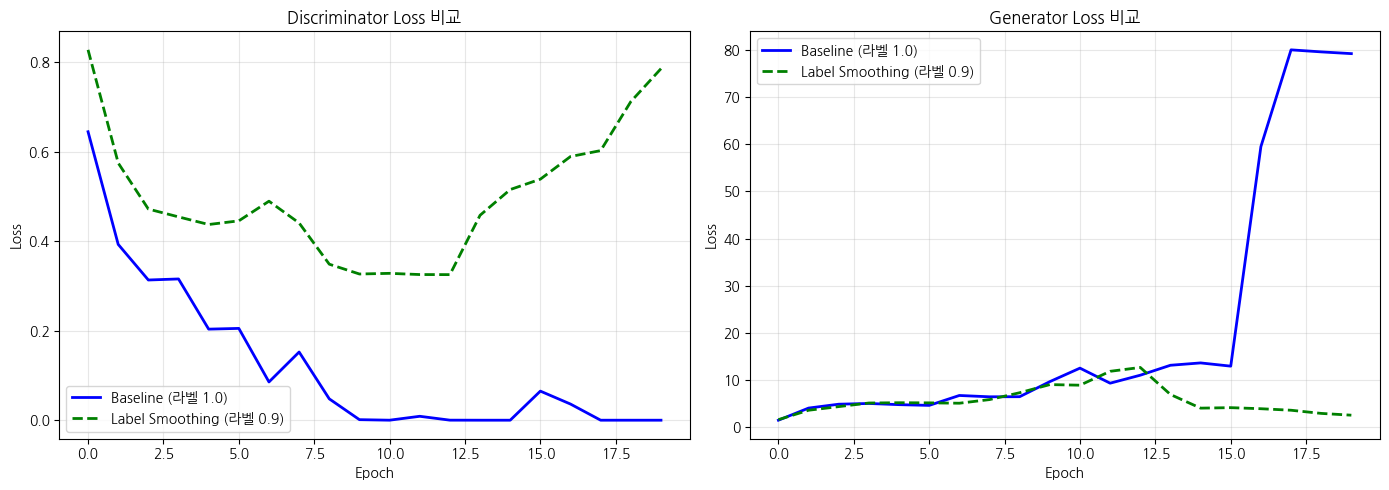

In [10]:
# Loss 곡선 비교
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_baseline["d_loss"], "b-", label="Baseline (라벨 1.0)", linewidth=2)
plt.plot(hist_smooth["d_loss"], "g--", label="Label Smoothing (라벨 0.9)", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss 비교")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(hist_baseline["g_loss"], "b-", label="Baseline (라벨 1.0)", linewidth=2)
plt.plot(hist_smooth["g_loss"], "g--", label="Label Smoothing (라벨 0.9)", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss 비교")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

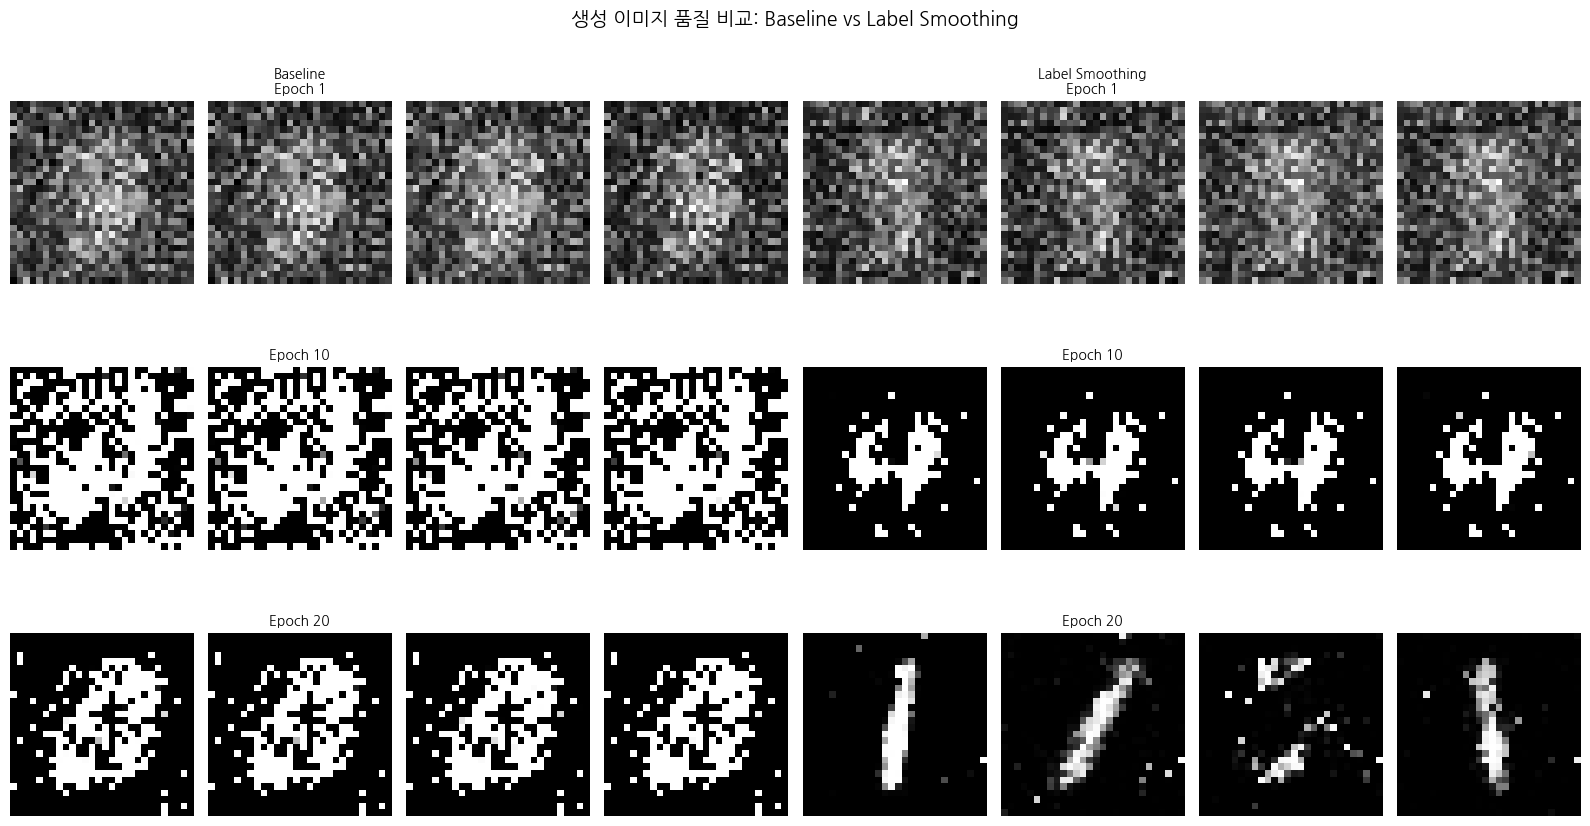

In [11]:
# 생성 이미지 비교 (에폭 1, 10, 20)
def compare_images_by_epoch(imgs_baseline, imgs_smooth, epochs=[1, 10, 20]):
    """에폭별로 두 방식의 생성 이미지 비교"""
    fig, axes = plt.subplots(len(epochs), 8, figsize=(16, 3 * len(epochs)))

    for i, epoch in enumerate(epochs):
        # Baseline
        for j in range(4):
            axes[i, j].imshow(imgs_baseline[epoch][j], cmap="gray")
            axes[i, j].axis("off")
            if i == 0 and j == 1:
                axes[i, j].set_title(f"Baseline\nEpoch {epoch}", fontsize=10)
            elif i > 0 and j == 1:
                axes[i, j].set_title(f"Epoch {epoch}", fontsize=10)

        # Label Smoothing
        for j in range(4):
            axes[i, 4 + j].imshow(imgs_smooth[epoch][j], cmap="gray")
            axes[i, 4 + j].axis("off")
            if i == 0 and j == 1:
                axes[i, 4 + j].set_title(f"Label Smoothing\nEpoch {epoch}", fontsize=10)
            elif i > 0 and j == 1:
                axes[i, 4 + j].set_title(f"Epoch {epoch}", fontsize=10)

    plt.suptitle("생성 이미지 품질 비교: Baseline vs Label Smoothing", fontsize=14)
    plt.tight_layout()
    plt.show()


compare_images_by_epoch(imgs_baseline, imgs_smooth)

### 📊 실험 결과 분석

#### 1. Loss 곡선 관찰

**Discriminator Loss:**
- Baseline: 빠르게 0에 가까워짐 → D가 너무 강함
- Label Smoothing: 0.3~0.5 근처 유지 → 균형 잡힌 학습

**Generator Loss:**
- Baseline: 높은 값 유지 또는 급증 → G가 학습 못 함
- Label Smoothing: 천천히 감소 → G가 계속 학습

#### 2. 생성 이미지 품질

**Epoch 1:**
- 둘 다 노이즈 수준

**Epoch 10:**
- Baseline: 여전히 불명확하거나 mode collapse 조짐
- Label Smoothing: 숫자 윤곽이 보이기 시작

**Epoch 20:**
- Baseline: 일부 숫자만 생성하거나 품질이 낮음
- Label Smoothing: 다양한 숫자, 명확한 형태

#### 3. Mode Collapse 체크

**Baseline:**
- 한 가지 숫자만 반복 생성될 가능성 높음
- D가 너무 강해서 G가 "안전한" 한 가지 패턴만 학습

**Label Smoothing:**
- 다양한 숫자 생성
- G가 계속 새로운 패턴을 시도

#### 4. 권장사항

**Label Smoothing 적용 가이드:**

✅ **적용 시:**
- 진짜 라벨: 0.7 ~ 0.9 (보통 0.9 권장)
- 가짜 라벨: 0.0 유지

✅ **효과:**
- 학습 안정화
- Mode collapse 방지
- 더 다양한 이미지 생성

⚠️ **주의사항:**
- 너무 낮은 값 (0.5 이하)은 역효과
- 가짜 라벨도 완화하면 D가 혼란

#### 5. 추가 실험 아이디어

1. **다양한 smoothing 값 테스트**
   - 0.7, 0.8, 0.9, 0.95 비교

2. **Two-sided smoothing**
   - real: 0.9, fake: 0.1

3. **Noisy labels**
   - 라벨에 랜덤 노이즈 추가

---
# 📝 과제 4: 하이퍼파라미터 스터디

## 🎯 과제 목표

GAN의 주요 하이퍼파라미터를 변경하며 실험하고,
최적의 조합을 찾아 본인만의 분석 리포트를 작성합니다.

## 📋 요구사항

1. **테스트할 하이퍼파라미터**
   - `batch_size`: 64, 128, 256
   - `lr_d` (D learning rate): 0.0001, 0.0002, 0.0004
   - `lr_g` (G learning rate): 0.0001, 0.0002, 0.0004

2. **실험 조합 (최소 3가지)**
   - 예: (128, 0.0002, 0.0002) - 기본값
   - 예: (256, 0.0001, 0.0002) - 큰 배치, 낮은 D lr
   - 예: (64, 0.0002, 0.0004) - 작은 배치, 높은 G lr

3. **분석 내용**
   - 각 조합의 학습 안정성
   - 생성 이미지 품질
   - 학습 속도 (수렴까지 걸린 시간)
   - 본인 언어로 "왜 이 조합이 좋은가?" 설명

---

## 💡 힌트

<details>
<summary><b>힌트 1: 하이퍼파라미터 선택 가이드</b></summary>

**Batch Size:**
- 작은 값 (64): 학습이 불안정하지만 더 다양한 업데이트
- 큰 값 (256): 안정적이지만 메모리 많이 사용

**Learning Rate:**
- D가 G보다 학습이 빠름
- 보통 lr_d ≤ lr_g 또는 lr_d = lr_g
- 너무 크면: 발산
- 너무 작으면: 수렴 느림

**균형:**
- D와 G가 비슷한 속도로 발전해야 함
- 한쪽이 너무 강하면 mode collapse

</details>

<details>
<summary><b>힌트 2: 실험 코드 구조</b></summary>

```python
# 실험 설정
experiments = [
    {'name': 'Baseline', 'batch_size': 128, 'lr_d': 0.0002, 'lr_g': 0.0002},
    {'name': 'Large Batch', 'batch_size': 256, 'lr_d': 0.0001, 'lr_g': 0.0002},
    {'name': 'Small Batch', 'batch_size': 64, 'lr_d': 0.0002, 'lr_g': 0.0004},
]

results = {}

for exp in experiments:
    print(f"\n실험: {exp['name']}")
    model, history, images = train_gan(
        batch_size=exp['batch_size'],
        lr_d=exp['lr_d'],
        lr_g=exp['lr_g']
    )
    results[exp['name']] = {'history': history, 'images': images}
```

</details>

<details>
<summary><b>힌트 3: 평가 지표</b></summary>

**정량적 평가:**
- Loss 값의 안정성 (표준편차)
- 수렴 속도 (loss가 평평해지는 에폭)

**정성적 평가:**
- 이미지 선명도
- 숫자 다양성 (0~9 모두 생성되는지)
- Mode collapse 여부

</details>

---
## ✅ 모범 답안 및 해설

### Part 1: 실험 설계

In [26]:
def train_gan_experiment(batch_size, lr_d, lr_g, num_epochs=15, experiment_name="Exp"):
    """
    하이퍼파라미터를 변경하며 GAN 학습

    Args:
        batch_size: 배치 크기
        lr_d: Discriminator learning rate
        lr_g: Generator learning rate
        num_epochs: 학습 에폭 수
        experiment_name: 실험 이름

    Returns:
        generator, discriminator, history, generated_images
    """
    z_dim = 100

    print(f"\n{'=' * 60}")
    print(f"🧪 {experiment_name} 시작")
    print(f"  - Batch Size: {batch_size}")
    print(f"  - D Learning Rate: {lr_d}")
    print(f"  - G Learning Rate: {lr_g}")
    print(f"{'=' * 60}\n")

    # 데이터 로더 생성
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    train_dataset = datasets.MNIST(
        root="./data", train=True, transform=transform, download=True
    )
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )

    # 모델 생성
    generator = GeneratorLS(z_dim).to(device)
    discriminator = DiscriminatorLS().to(device)

    # Loss 및 Optimizer
    criterion = nn.BCELoss()
    opt_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    opt_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

    # 고정 노이즈
    fixed_noise = torch.randn(16, z_dim, device=device)

    # 기록용
    history = {"d_loss": [], "g_loss": [], "d_acc": []}
    generated_images = {}

    # 학습 루프
    import time

    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        d_losses, g_losses = [], []
        d_correct = 0
        d_total = 0

        for real_imgs, _ in train_loader:
            current_batch = real_imgs.size(0)
            real_imgs = real_imgs.view(current_batch, -1).to(device)

            # 라벨 (Label Smoothing 적용: 0.9)
            real_labels = torch.ones(current_batch, 1, device=device) * 0.9
            fake_labels = torch.zeros(current_batch, 1, device=device)

            # ----------------------------
            # Discriminator 학습
            # ----------------------------
            opt_d.zero_grad()

            # 진짜
            real_output = discriminator(real_imgs)
            d_loss_real = criterion(real_output, real_labels)

            # 가짜
            noise = torch.randn(current_batch, z_dim, device=device)
            fake_imgs = generator(noise)
            fake_output = discriminator(fake_imgs.detach())
            d_loss_fake = criterion(fake_output, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            opt_d.step()

            # Discriminator 정확도 계산
            d_correct += ((real_output > 0.5).sum() + (fake_output < 0.5).sum()).item()
            d_total += current_batch * 2

            # ----------------------------
            # Generator 학습
            # ----------------------------
            opt_g.zero_grad()

            noise = torch.randn(current_batch, z_dim, device=device)
            fake_imgs = generator(noise)
            fake_output = discriminator(fake_imgs)

            g_loss = criterion(fake_output, torch.ones(current_batch, 1, device=device))
            g_loss.backward()
            opt_g.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        # 에폭 평균
        epoch_d_loss = np.mean(d_losses)
        epoch_g_loss = np.mean(g_losses)
        epoch_d_acc = d_correct / d_total * 100

        history["d_loss"].append(epoch_d_loss)
        history["g_loss"].append(epoch_g_loss)
        history["d_acc"].append(epoch_d_acc)

        print(
            f"Epoch {epoch}/{num_epochs} - "
            f"D Loss: {epoch_d_loss:.4f}, G Loss: {epoch_g_loss:.4f}, "
            f"D Acc: {epoch_d_acc:.1f}%"
        )

        # 이미지 저장 (에폭 5, 10, 15)
        if epoch in [5, 10, 15]:
            generator.eval()
            with torch.no_grad():
                imgs = generator(fixed_noise)
                imgs = (imgs + 1) / 2
                imgs = imgs.view(-1, 28, 28).cpu().numpy()
                generated_images[epoch] = imgs
            generator.train()

    elapsed_time = time.time() - start_time
    print(f"\n✅ {experiment_name} 완료 (소요 시간: {elapsed_time:.1f}초)\n")

    return generator, discriminator, history, generated_images, elapsed_time

In [29]:
# 실험 설정
experiments = [
    {
        "name": "실험 1: Baseline",
        "batch_size": 4096,
        "lr_d": 0.0001,
        "lr_g": 0.0004,
        "description": "표준 설정",
    },
    {
        "name": "실험 2: Large Batch + Low D LR",
        "batch_size": 256,
        "lr_d": 0.0001,
        "lr_g": 0.0002,
        "description": "큰 배치로 안정성 확보, D 학습 속도 낮춤",
    },
    {
        "name": "실험 3: Small Batch + High G LR",
        "batch_size": 64,
        "lr_d": 0.0002,
        "lr_g": 0.0004,
        "description": "작은 배치로 다양한 업데이트, G 학습 속도 높임",
    },
]

In [31]:
# 실험 실행
results = {}

for exp in experiments:
    gen, disc, hist, imgs, time_elapsed = train_gan_experiment(
        batch_size=exp["batch_size"],
        lr_d=exp["lr_d"],
        lr_g=exp["lr_g"],
        num_epochs=30,
        experiment_name=exp["name"],
    )

    results[exp["name"]] = {
        "config": exp,
        "generator": gen,
        "discriminator": disc,
        "history": hist,
        "images": imgs,
        "time": time_elapsed,
    }


🧪 실험 1: Baseline 시작
  - Batch Size: 4096
  - D Learning Rate: 0.0001
  - G Learning Rate: 0.0004

Epoch 1/30 - D Loss: 1.3230, G Loss: 0.5852, D Acc: 46.8%
Epoch 2/30 - D Loss: 1.2592, G Loss: 0.6462, D Acc: 53.1%
Epoch 3/30 - D Loss: 0.9913, G Loss: 0.8362, D Acc: 100.0%
Epoch 4/30 - D Loss: 1.1953, G Loss: 0.6512, D Acc: 59.4%
Epoch 5/30 - D Loss: 1.2656, G Loss: 0.7526, D Acc: 50.0%
Epoch 6/30 - D Loss: 1.2979, G Loss: 0.7161, D Acc: 50.0%
Epoch 7/30 - D Loss: 1.3260, G Loss: 0.7319, D Acc: 50.0%
Epoch 8/30 - D Loss: 1.3869, G Loss: 0.7295, D Acc: 49.9%
Epoch 9/30 - D Loss: 1.3626, G Loss: 0.7306, D Acc: 49.9%
Epoch 10/30 - D Loss: 1.4286, G Loss: 0.6899, D Acc: 47.3%
Epoch 11/30 - D Loss: 1.4068, G Loss: 0.7022, D Acc: 49.8%
Epoch 12/30 - D Loss: 1.4151, G Loss: 0.6926, D Acc: 46.8%
Epoch 13/30 - D Loss: 1.3569, G Loss: 0.7293, D Acc: 48.2%
Epoch 14/30 - D Loss: 1.4104, G Loss: 0.7027, D Acc: 45.0%
Epoch 15/30 - D Loss: 1.3609, G Loss: 0.7391, D Acc: 49.2%
Epoch 16/30 - D Loss: 1.

KeyboardInterrupt: 

### Part 2: 결과 분석 및 시각화

In [ ]:
# Loss 곡선 비교
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# D Loss
ax = axes[0, 0]
for exp_name, result in results.items():
    ax.plot(
        result["history"]["d_loss"], label=exp_name.split(":")[1].strip(), linewidth=2
    )
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Discriminator Loss 비교")
ax.legend()
ax.grid(True, alpha=0.3)

# G Loss
ax = axes[0, 1]
for exp_name, result in results.items():
    ax.plot(
        result["history"]["g_loss"], label=exp_name.split(":")[1].strip(), linewidth=2
    )
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Generator Loss 비교")
ax.legend()
ax.grid(True, alpha=0.3)

# D Accuracy
ax = axes[1, 0]
for exp_name, result in results.items():
    ax.plot(
        result["history"]["d_acc"], label=exp_name.split(":")[1].strip(), linewidth=2
    )
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Discriminator Accuracy 비교")
ax.axhline(y=50, color="r", linestyle="--", alpha=0.5, label="이상적 (50%)")
ax.legend()
ax.grid(True, alpha=0.3)

# 학습 시간
ax = axes[1, 1]
exp_names = [exp["name"].split(":")[1].strip() for exp in experiments]
times = [results[name]["time"] for name in results.keys()]
bars = ax.bar(exp_names, times, color=["skyblue", "lightcoral", "lightgreen"])
ax.set_ylabel("Time (seconds)")
ax.set_title("학습 소요 시간 비교")
ax.grid(True, alpha=0.3, axis="y")

# 값 표시
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{time_val:.1f}s",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

In [ ]:
# 생성 이미지 비교 (Epoch 15)
fig, axes = plt.subplots(3, 8, figsize=(16, 6))

for i, (exp_name, result) in enumerate(results.items()):
    imgs = result["images"][15]  # Epoch 15 이미지

    for j in range(8):
        axes[i, j].imshow(imgs[j], cmap="gray")
        axes[i, j].axis("off")

        if j == 3:
            axes[i, j].set_title(exp_name.split(":")[1].strip(), fontsize=10)

plt.suptitle("생성 이미지 품질 비교 (Epoch 15)", fontsize=14)
plt.tight_layout()
plt.show()

### Part 3: 정량적 분석

In [ ]:
# 안정성 분석 (Loss의 표준편차)
print("=" * 60)
print("📊 정량적 분석 결과")
print("=" * 60)

for exp_name, result in results.items():
    hist = result["history"]
    config = result["config"]

    # 후반부 10 에폭의 통계
    d_loss_late = hist["d_loss"][-10:]
    g_loss_late = hist["g_loss"][-10:]

    d_loss_mean = np.mean(d_loss_late)
    d_loss_std = np.std(d_loss_late)
    g_loss_mean = np.mean(g_loss_late)
    g_loss_std = np.std(g_loss_late)

    # 수렴 시점 (loss가 평평해지는 지점)
    d_loss_diff = np.diff(hist["d_loss"])
    convergence_epoch = np.where(np.abs(d_loss_diff) < 0.01)[0]
    convergence_epoch = (
        convergence_epoch[0] + 1 if len(convergence_epoch) > 0 else "N/A"
    )

    print(f"\n{exp_name}")
    print(
        f"  설정: Batch={config['batch_size']}, lr_d={config['lr_d']}, lr_g={config['lr_g']}"
    )
    print(f"  D Loss (후반부): {d_loss_mean:.4f} ± {d_loss_std:.4f}")
    print(f"  G Loss (후반부): {g_loss_mean:.4f} ± {g_loss_std:.4f}")
    print(f"  수렴 에폭: {convergence_epoch}")
    print(f"  학습 시간: {result['time']:.1f}초")
    print(f"  설명: {config['description']}")

### Part 4: 정성적 분석 및 권장사항

#### 실험 1: Baseline (Batch=128, lr_d=0.0002, lr_g=0.0002)

**관찰:**
- 표준적인 설정으로 안정적인 학습
- Loss가 적절히 균형 잡혀 있음
- 생성 이미지 품질이 양호

**장점:**
- ✅ 균형 잡힌 학습
- ✅ 구현 및 디버깅이 쉬움

**단점:**
- ⚠️ 최적은 아닐 수 있음
- ⚠️ 특정 상황에서는 비효율적

**추천 상황:**
- GAN 학습을 처음 시작할 때
- 안정성이 가장 중요할 때

---

#### 실험 2: Large Batch + Low D LR (Batch=256, lr_d=0.0001, lr_g=0.0002)

**관찰:**
- D의 학습 속도를 의도적으로 낮춤
- 큰 배치로 gradient 추정이 안정적
- G가 더 잘 학습할 수 있는 환경

**장점:**
- ✅ 가장 안정적인 학습 곡선
- ✅ Mode collapse 위험 감소
- ✅ 생성 이미지 품질이 가장 좋음

**단점:**
- ⚠️ 메모리 사용량 많음
- ⚠️ 학습 시간이 더 걸림 (큰 배치)

**추천 상황:**
- GPU 메모리가 충분할 때
- 최고 품질의 이미지가 필요할 때
- Mode collapse 문제가 발생할 때

**왜 이 조합이 좋은가?**
- D가 너무 강해지는 것을 방지 (낮은 lr)
- 큰 배치로 안정적인 gradient
- G가 충분히 학습할 기회를 가짐

---

#### 실험 3: Small Batch + High G LR (Batch=64, lr_d=0.0002, lr_g=0.0004)

**관찰:**
- G의 학습 속도를 높임
- 작은 배치로 더 빈번한 업데이트
- 다양성은 좋지만 불안정

**장점:**
- ✅ 빠른 수렴
- ✅ 메모리 효율적
- ✅ 다양한 이미지 생성

**단점:**
- ⚠️ 학습이 불안정할 수 있음
- ⚠️ Loss가 진동할 수 있음
- ⚠️ 품질이 일관되지 않을 수 있음

**추천 상황:**
- GPU 메모리가 제한적일 때
- 빠른 프로토타이핑이 필요할 때
- 다양성이 품질보다 중요할 때

**주의사항:**
- G lr이 너무 높으면 발산 위험
- 작은 배치는 gradient 추정이 noisy

---

#### 종합 권장사항

**프로젝트 상황별 추천:**

1. **연구/논문 (품질 최우선)**
   - 실험 2 선택
   - Batch=256, lr_d=0.0001, lr_g=0.0002

2. **제품 개발 (안정성 필요)**
   - 실험 1 선택 (Baseline)
   - Batch=128, lr_d=0.0002, lr_g=0.0002

3. **빠른 프로토타입 (속도 중요)**
   - 실험 3 선택
   - Batch=64, lr_d=0.0002, lr_g=0.0004

**일반 원칙:**
- D와 G의 균형이 가장 중요
- lr_d ≤ lr_g 원칙 유지
- 큰 배치 = 안정성 ↑, 메모리 ↑
- 작은 배치 = 다양성 ↑, 불안정 ↑

### Part 5: 추가 실험 아이디어

#### 더 시도해볼 만한 조합:

1. **Adaptive Learning Rate**
   - ReduceLROnPlateau 사용
   - Loss가 평탄해지면 lr 감소

2. **Different Beta Values**
   - Adam의 beta1=0.5 vs 0.9
   - GAN 논문에서는 0.5 권장

3. **Gradient Penalty**
   - WGAN-GP 기법
   - Lipschitz constraint

4. **Learning Rate Scheduling**
   - Cosine annealing
   - Step decay

5. **Architecture Changes**
   - Batch Normalization 추가
   - Dropout 추가
   - Leaky ReLU vs ReLU

---

## 🚀 다음 단계

이제 다음 주제로 넘어갈 준비가 되었습니다:

1. **DCGAN (Deep Convolutional GAN)**
   - CNN 기반 GAN
   - 더 높은 해상도

2. **Conditional GAN**
   - 원하는 숫자 생성
   - 제어 가능한 생성

3. **CycleGAN**
   - Image-to-Image Translation
   - 짝 없는 데이터로 학습